# **LENDING CLUB CASE STUDY** 
## **Group Members :**
### **1. Karthick Chetti** - Group Fecilitator
### **2. Anirudh KVC** - Collaborator

## **Index of Notebook**
1. Objectives
2. Understanding Data
3. Data Cleaning
4. Selecting columns based on business objectives
5. Missing Value Imputation
6. Understanding variables and their datatypes


## **1. Objectives :**
1. Understanding the driving factors behind loan default thereby aiming to reduce credit loss 
2. Data Driven inferences to support the driving factors

In [130]:
# Load the libraries
import pandas as pd #To work with dataset
pd.set_option("display.max_columns", 100)
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from matplotlib.ticker import PercentFormatter # for percentage

In [131]:
# Importing data from loan.csv
loan_df=pd.read_csv("loan.csv")

C:\Users\user\Documents\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### **2. Understanding Data** 

In [132]:
loan_df.info(verbose=True,show_counts=True)
init_cols=len(loan_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258 non-null  object 
 11   emp_length                      38642 non-null  object 
 12   home_ownership  

#### We can see that there are some null values in the columns and there are too many columns to analyze, hence measures have to be taken to clean data based on *business objectives* and based on *statistics*

### **3. Data Cleaning** : Based on Business Objective
### Filtering out data based on objective, since we are restricting our analysis to Charged off customers in the interest for the business objective

In [133]:
# Filtering data accorgingly
loan_df = loan_df[loan_df["loan_status"] == "Charged Off"]

### **3. Data Cleaning** : A) Removing Columns with high percentage of null values

In [134]:
#Removing columns having 50% null values in them as such columns are not useful for analysis
lc_df=loan_df.dropna(axis=1,thresh=int(0.5*len(loan_df)))

In [135]:
#Printing number of columns removed
removed_columns=len(loan_df.columns)-len(lc_df.columns)
print(f"{removed_columns} columns were removed from original dataframe due to high amount of missing values in them")

57 columns were removed from original dataframe due to high amount of missing values in them


### **3. Data Cleaning** : B) Removing Columns with same values which are redundant for analysis

In [136]:
#### It is observed that some columns have only one value(mostly 0) throughout the rows, which are not useful for the analysis
dropped_col=[]
for col in lc_df.columns:
    if len(lc_df[col].unique())==1:
        dropped_col.append(col)
print(f"{len(dropped_col)} columns are dropped in the dataframe due to same values repeating throughout the column")
lc_df=lc_df.drop(dropped_col,axis=1)

9 columns are dropped in the dataframe due to same values repeating throughout the column


### **3. Data Cleaning** : C) Removing Columns with either 0s or missing values in them

In [137]:
for c in lc_df.columns:
    if len(lc_df[c].unique())==2:
        print(lc_df[c].unique())

[' 60 months' ' 36 months']
[ 0. nan]
[ 0. nan]
[ 0. nan]


In [138]:
no_uniq_cols=["collections_12_mths_ex_med","chargeoff_within_12_mths","tax_liens"]
lc_df.drop(no_uniq_cols,axis=1,inplace=True)
print(f"{len(no_uniq_cols)} columns are dropped since they don't have meaningful unique values for analysis")

3 columns are dropped since they don't have meaningful unique values for analysis


In [139]:
exis_cols=len(lc_df.columns)
print(f"As a result of data cleaning, out of {init_cols} columns, {exis_cols} columns exist.\nHowever it is important to select the most relevant columns out of these {exis_cols} for analysis")

As a result of data cleaning, out of 111 columns, 42 columns exist.
However it is important to select the most relevant columns out of these 42 for analysis


### **4. Selecting most relevant features as per business objective** 
### Additional features/columns will be added to the analysis in the future if it's found relevant

In [140]:
# Key features
# id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,verification_status,purpose,zip_code,add_state
# Here id is conidered for aggregation purpose
req_features=["id","loan_amnt","term","int_rate","grade","sub_grade","home_ownership","emp_length","annual_inc","verification_status","purpose","addr_state","dti","open_acc","total_acc","delinq_2yrs","earliest_cr_line"]
lc_df = lc_df[req_features]

In [141]:
# Having a look at the data
lc_df.head()

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,emp_length,annual_inc,verification_status,purpose,addr_state,dti,open_acc,total_acc,delinq_2yrs,earliest_cr_line
1,1077430,2500,60 months,15.27%,C,C4,RENT,< 1 year,30000.0,Source Verified,car,GA,1.00,3,4,0,Apr-99
8,1071795,5600,60 months,21.28%,F,F2,OWN,4 years,40000.0,Source Verified,small_business,CA,5.55,11,13,0,Apr-04
9,1071570,5375,60 months,12.69%,B,B5,RENT,< 1 year,15000.0,Verified,other,TX,18.08,2,3,0,Sep-04
12,1064687,9000,36 months,13.49%,C,C1,RENT,< 1 year,30000.0,Source Verified,debt_consolidation,VA,10.08,4,9,0,Apr-04
14,1069057,10000,36 months,10.65%,B,B2,RENT,3 years,100000.0,Source Verified,other,CA,7.06,14,29,0,May-91


In [142]:
# Understanding the data and data types
lc_df.info(verbose=True,show_counts=True)
lc_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5627 entries, 1 to 39688
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5627 non-null   int64  
 1   loan_amnt            5627 non-null   int64  
 2   term                 5627 non-null   object 
 3   int_rate             5627 non-null   object 
 4   grade                5627 non-null   object 
 5   sub_grade            5627 non-null   object 
 6   home_ownership       5627 non-null   object 
 7   emp_length           5399 non-null   object 
 8   annual_inc           5627 non-null   float64
 9   verification_status  5627 non-null   object 
 10  purpose              5627 non-null   object 
 11  addr_state           5627 non-null   object 
 12  dti                  5627 non-null   float64
 13  open_acc             5627 non-null   int64  
 14  total_acc            5627 non-null   int64  
 15  delinq_2yrs          5627 non-null   

,id,loan_amnt,annual_inc,dti,open_acc,total_acc,delinq_2yrs
count,5.627000e+03,5627.000000,5.627000e+03,5627.000000,5627.000000,5627.000000,5627.000000
mean,6.978440e+05,12104.385108,6.242730e+04,14.000624,9.178070,21.427581,0.170606
std,2.163767e+05,8085.732038,4.777601e+04,6.585577,4.525937,11.447427,0.534986
min,6.141900e+04,900.000000,4.080000e+03,0.000000,2.000000,2.000000,0.000000
25%,5.297245e+05,5600.000000,3.700000e+04,9.050000,6.000000,13.000000,0.000000
50%,6.969370e+05,10000.000000,5.300000e+04,14.290000,8.000000,20.000000,0.000000
75%,8.548760e+05,16500.000000,7.500000e+04,19.290000,12.000000,28.000000,0.000000
max,1.077430e+06,35000.000000,1.250000e+06,29.850000,38.000000,74.000000,8.000000


### **5. Missing value imputation**

### There are some columns which have missing values,Therefore understanding the number of missing values in these columns

In [143]:
empty_cols=lc_df.columns[lc_df.isna().any()].tolist()
empty_vals=[lc_df[col].isna().sum() for col in empty_cols]
empty_per_dict=dict(zip(empty_cols,empty_vals))
print("The missing values in columns is :\n",empty_per_dict)

The missing values in columns is :
 {'emp_length': 228}


#### It is observed that in selected columns for analysis, 'emp_length' column has some missing data

In [144]:
# As the number of missing data is less, missing value imputation can be done
# Checking the values in emp_length column
lc_df["emp_length"].value_counts()

10+ years    1331
< 1 year      639
2 years       567
3 years       555
4 years       462
5 years       458
1 year        456
6 years       307
7 years       263
8 years       203
9 years       158
Name: emp_length, dtype: int64

In [145]:
# As the most recurring value is 10+years, adding 10+ years whereever the data is missing
lc_df["emp_length"] = lc_df["emp_length"].fillna(lc_df["emp_length"].value_counts().index[0])

### **6. Understanding variables and their datatypes**

In [146]:
#Understanding the datatypes in the dataframe
lc_df.info(verbose=True,show_counts=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5627 entries, 1 to 39688
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   loan_amnt            int64  
 2   term                 object 
 3   int_rate             object 
 4   grade                object 
 5   sub_grade            object 
 6   home_ownership       object 
 7   emp_length           object 
 8   annual_inc           float64
 9   verification_status  object 
 10  purpose              object 
 11  addr_state           object 
 12  dti                  float64
 13  open_acc             int64  
 14  total_acc            int64  
 15  delinq_2yrs          int64  
 16  earliest_cr_line     object 
dtypes: float64(2), int64(5), object(10)
memory usage: 791.3+ KB


In [147]:
# Removing % and converting to float
lc_df["int_rate"]=lc_df["int_rate"].str.replace("%","").astype(float)

### **Understanding type of variable for analysis**
1. **Numeric Data** : <br>
loan_amt,int_rate,installment,annual_inc,dti

2. **Ordered Categorical Data** : <br>
term,grade,sub_grade,emp_length,verification_status,open_acc,total_acc,delinq_2yrs,earliest_cr_line

3. **Unordered Categorical Data** : <br>
home_ownership,purpose,zip_code,addr_state

*id column can be used as a unique row identifier*

In [148]:
#Declaring type of variables
numeric_data=["loan_amnt","int_rate","annual_inc","dti"]
ordered_cat_data=["term","grade","sub_grade","emp_length","open_acc","total_acc","delinq_2yrs","earliest_cr_line"]
unordered_cat_data=["home_ownership","purpose","verification_status","zip_code","addr_state"]

### **7. Data Distribution and Outlier Correction for Numeric Data**

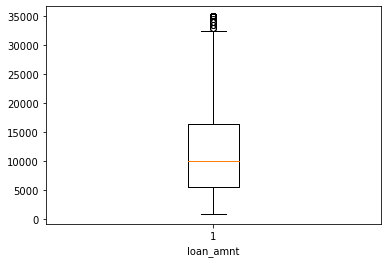

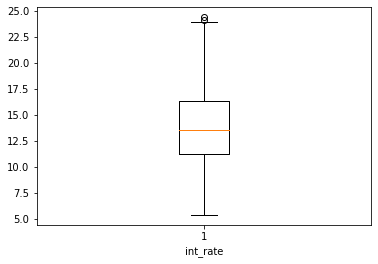

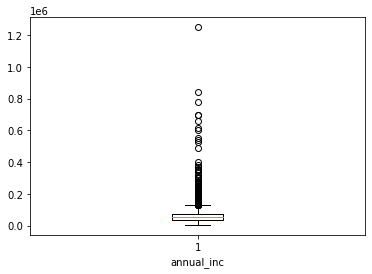

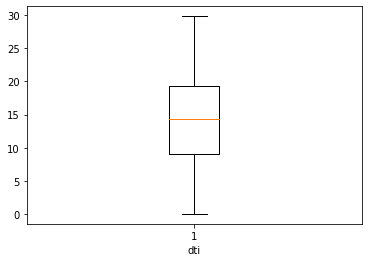

In [149]:
#Checking the distributions for numeric data
#Function to plot box plots taking dataframe and columns as input
def box_plot_col(df,cols):
    for col in cols:
        plt.boxplot(df[col])
        plt.xlabel(col)
        plt.show()
box_plot_col(lc_df,numeric_data)

### Outliers are detected in the box plot for some variables, it is important to remove outliers in the data based on a  IQR 

In [150]:
#Remove outliers based on IQR (Taking Threshold as 15%)
def remove_outliers(df,cols):
    for col in cols:
        ser=df[col]
        Q1 = ser.quantile(0.15)
        Q3 = ser.quantile(0.85)
        IQR = Q3 - Q1
        df = df[~(ser > (Q3 + 1.5 * IQR))]
    return df
lc_df=remove_outliers(lc_df,numeric_data)
removed_data_points=len(loan_df)-len(lc_df)
print(f"{removed_data_points} data points were removed because they were outliers in the numeric data columns")

103 data points were removed because they were outliers in the numeric data columns


### Univariate Analysis

In [151]:
lc_df

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,emp_length,annual_inc,verification_status,purpose,addr_state,dti,open_acc,total_acc,delinq_2yrs,earliest_cr_line
1,1077430,2500,60 months,15.27,C,C4,RENT,< 1 year,30000.0,Source Verified,car,GA,1.00,3,4,0,Apr-99
8,1071795,5600,60 months,21.28,F,F2,OWN,4 years,40000.0,Source Verified,small_business,CA,5.55,11,13,0,Apr-04
9,1071570,5375,60 months,12.69,B,B5,RENT,< 1 year,15000.0,Verified,other,TX,18.08,2,3,0,Sep-04
12,1064687,9000,36 months,13.49,C,C1,RENT,< 1 year,30000.0,Source Verified,debt_consolidation,VA,10.08,4,9,0,Apr-04
14,1069057,10000,36 months,10.65,B,B2,RENT,3 years,100000.0,Source Verified,other,CA,7.06,14,29,0,May-91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39666,119043,15450,36 months,11.22,C,C4,MORTGAGE,2 years,40000.0,Not Verified,debt_consolidation,VA,13.50,13,29,0,Nov-92
39667,118823,2500,36 months,12.80,D,D4,MORTGAGE,< 1 year,32000.0,Not Verified,home_improvement,NE,20.00,11,32,0,Jul-92
39668,118533,2500,36 months,9.64,B,B4,MORTGAGE,< 1 year,75000.0,Not Verified,home_improvement,NE,20.00,9,35,0,Feb-94
39678,113179,1000,36 months,10.59,C,C2,MORTGAGE,2 years,33990.0,Not Verified,wedding,VA,14.47,9,11,0,Jul-04


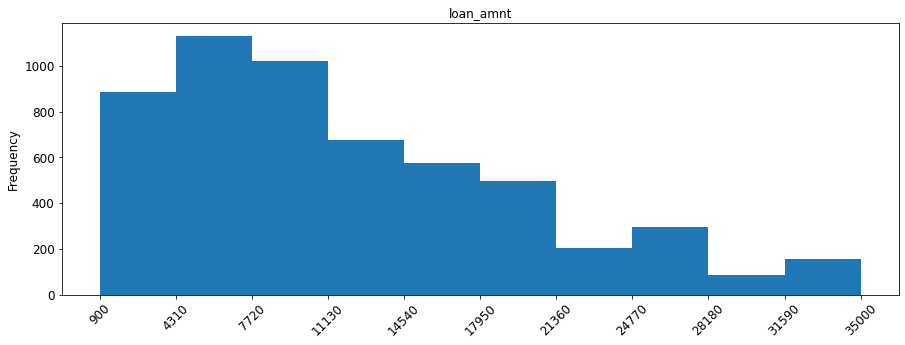

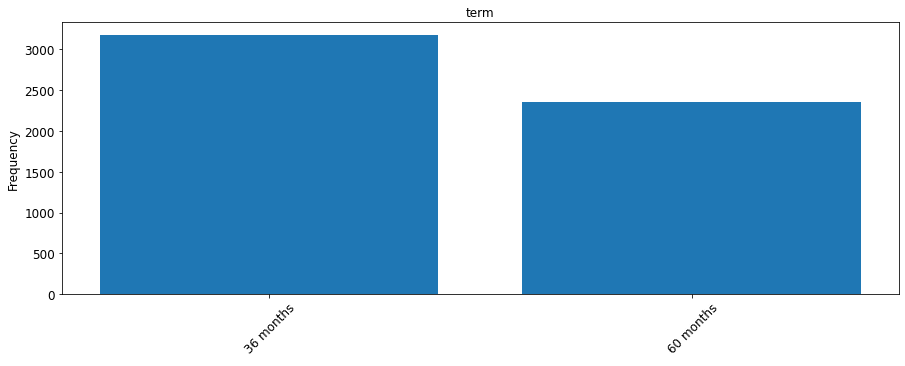

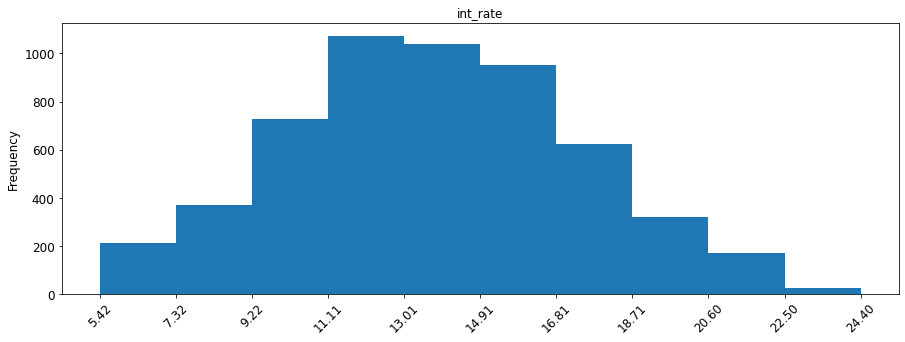

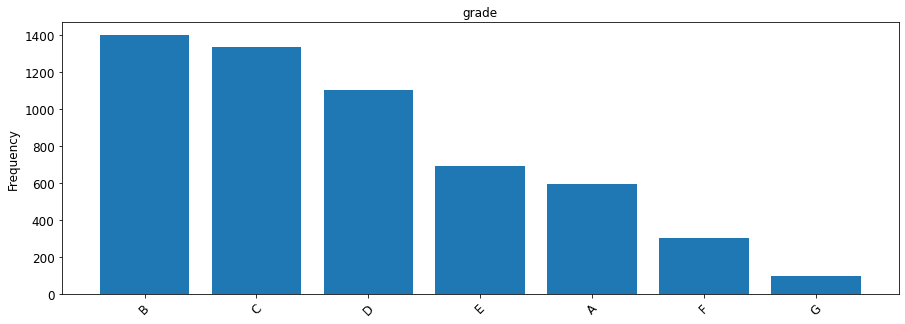

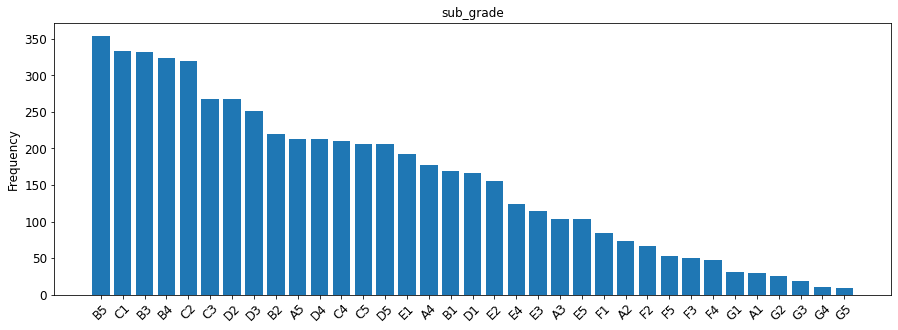

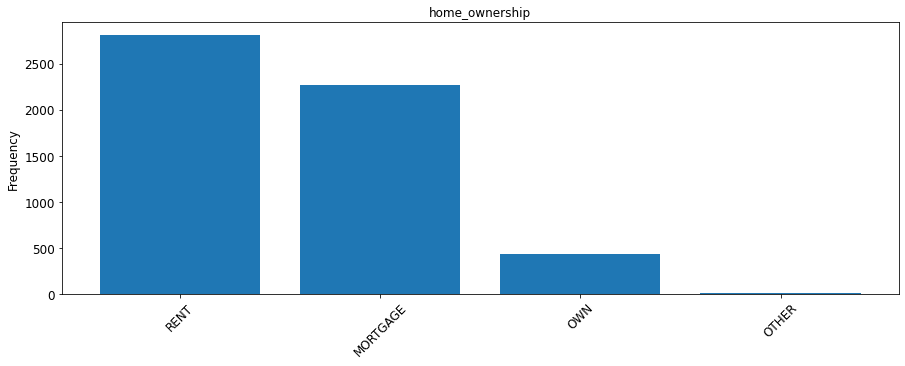

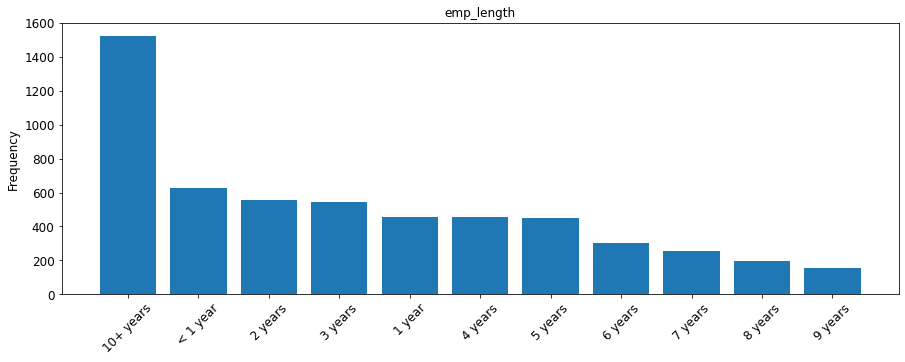

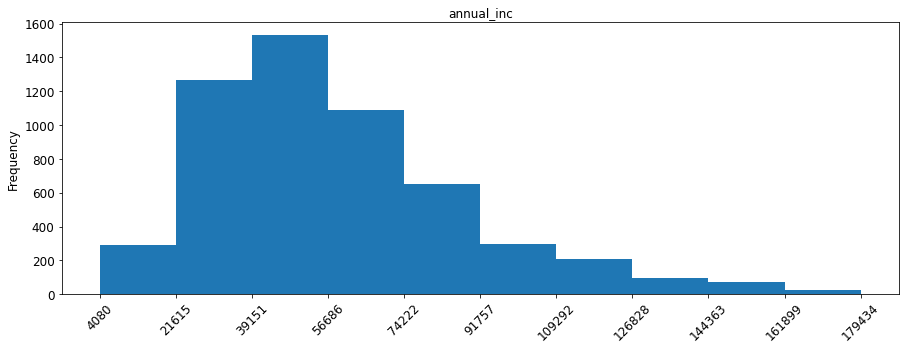

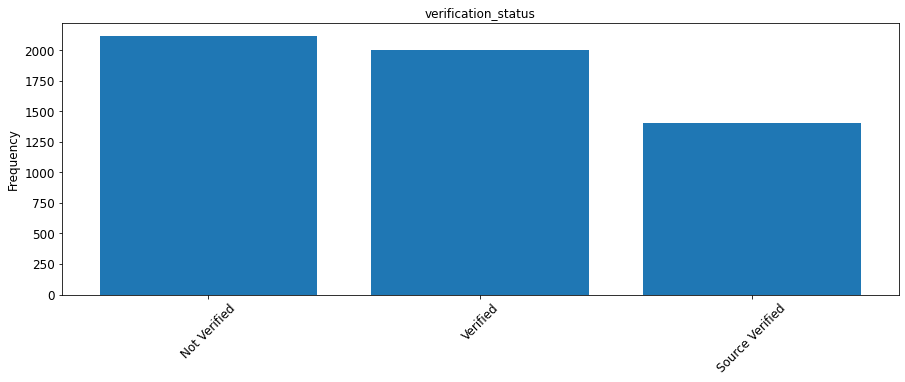

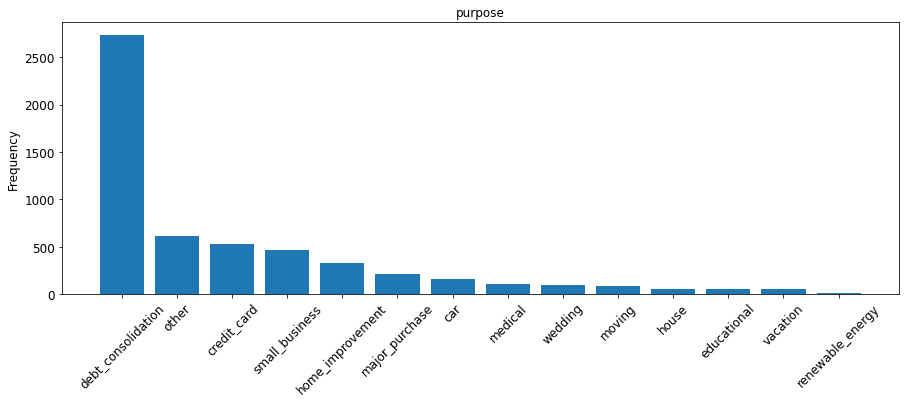

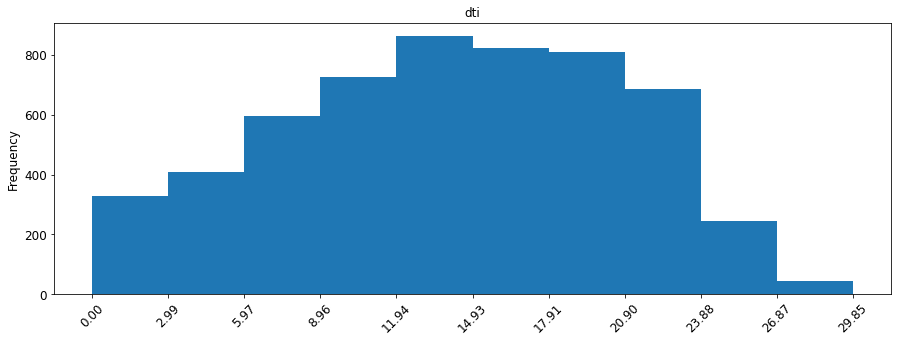

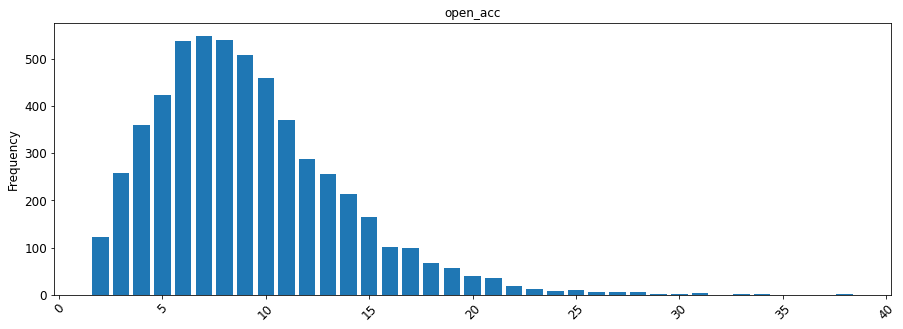

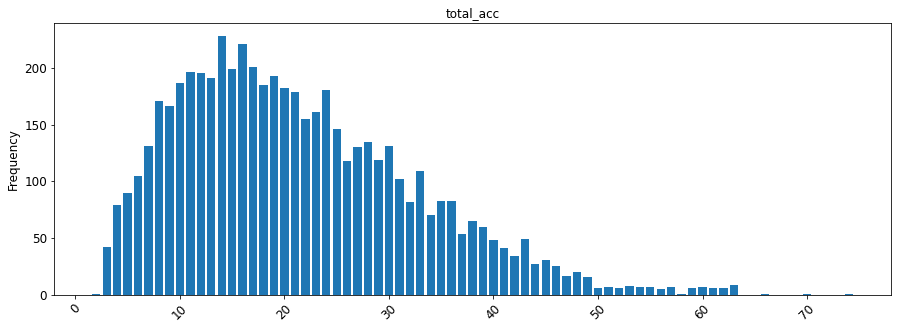

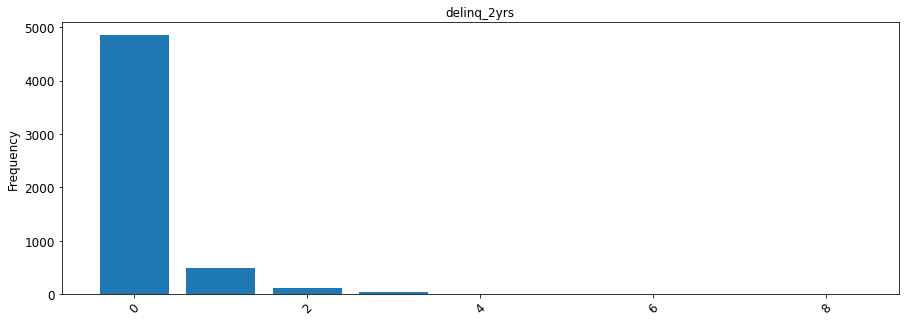

In [152]:
for col in lc_df.columns:
    if col in ['loan_amnt', 'term', 'int_rate', 'grade',
       'sub_grade', 'home_ownership', 'emp_length', 'loan_status',
       'annual_inc', 'verification_status', 'purpose', 'dti', 'open_acc', 'total_acc', 'delinq_2yrs',]:
        plt.figure(figsize=(15,5))
        if col in numeric_data:
            n,bins,_=plt.hist(lc_df[col])
            plt.xticks(bins,fontsize=12,rotation = 45)
        else:
            plt.bar(lc_df[col].value_counts().index,lc_df[col].value_counts().values)
            plt.xticks(fontsize=12,rotation = 45)
        plt.title(col)
        plt.ylabel("Frequency",fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

## Inferences from univariate analysis
### 1. Majority of charged off loan amounts are taken between 4000 to 11000
### 2. Loans taken for term of 36 months have more charged off customers compared to loan term of 60 months
### 3. More charged off people take loans in 11-15% interest rate
### 4. Loans offered in B,C,D grades have high charged off customers with B5 sub grade having the highest
### 5. People with rented or mortgaged homes are mostly charging off compared to other categories
### 6. Employees with experience more than 10 years majorly charge off
### 7. Employees having annual income between 40000 to 55000 majorly charge off
### 8. People taking loans for debt consolidation are significantly charge off more
### 9. Customers whose data is not verified tend to charge off more
### 10. Customers whose dti is between 12-21 charge off more compared to other dti ratios



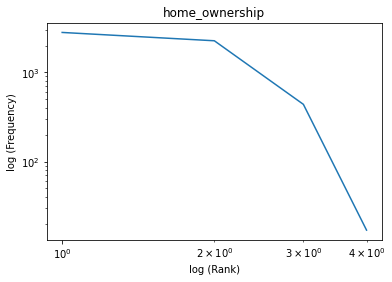

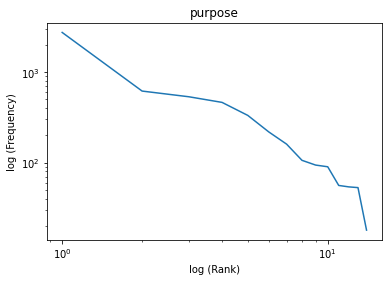

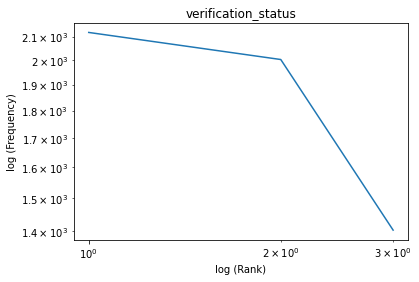

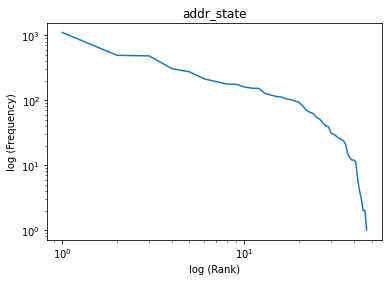

In [153]:
#Unordered categorical variables
for i in unordered_cat_data:
    if i!="zip_code":
        x_data = np.arange(1,len(lc_df[i].value_counts())+1)
        y_data = lc_df[i].value_counts().values
        plt.loglog(x_data,y_data)
        plt.xlabel("log (Rank)")
        plt.ylabel("log (Frequency)")
        plt.title(i)
        plt.show()


In [154]:
# From the rank vs frequency plots it can be inferred that purpose follows nearly power law distribution

## **8. Bivariate Analysis**

### Since univariate analysis is not fully indicative of the business objective to find out the driving variables for charged off customers, 
### We are visualizing the insights with respect to **fully paid** and **charged off** customers

In [218]:
# Functions for plotting bar chart for categorical variables
def plot_bar_cat(df,index_name,column_name,width,x_lbl_rotation):
    pivot=pd.pivot_table(df,values="id",index=index_name,columns=column_name,aggfunc=lambda x: len(x.unique()))
    plt.figure(figsize=(15,5))
    x_label = pivot.index
    x_data = np.arange(len(x_label)) # create values from 0 to len(x_label) - 1
    #height_data = (df[df["loan_status"]=="Fully Paid"][column_name].value_counts().values,df[df["loan_status"]=="Charged Off"][column_name].value_counts().values)
    chart=[]
    for j,i in enumerate(pivot.columns):
        chart.append(plt.bar(x_data + j*(width), pivot[i],width=width,align="edge"))
    plt.xlabel(index_name,fontsize=22)
    plt.ylabel("Frequency",fontsize=22)
    x_label_pos = x_data + (len(pivot.columns)*width)/2
    plt.xticks(x_label_pos ,x_label,fontsize=15,rotation = x_lbl_rotation)
    plt.yticks(fontsize=15)
    plt.legend(chart,pivot.columns,fontsize=15)
    plt.show()

def plot_bar_cat_stack(df,index_name,column_name,width,x_lbl_rotation,title):
    ind_len=len(df[index_name].value_counts())
    col_len=len(df[column_name].value_counts())
    #Plotting more categories on x axis
    if ind_len>=col_len:
        index_pivot=index_name
        col_pivot=column_name
    else:
        index_pivot=column_name
        col_pivot=index_name      
    pivot=pd.pivot_table(df,values="id",index=index_pivot,columns=col_pivot,aggfunc=lambda x: len(x.unique()))
    pivot.plot(kind='bar', stacked=True,figsize=(15,5),use_index=True,title=title,rot=x_lbl_rotation,fontsize=12)
    plt.xlabel(pivot.index.names[0],fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
    plt.show()

### **9. Derived Metrics and Binning for Ordered Categorical Variables**

In [156]:
# Functions for plotting graphs wrt columns (numerical) as percentage
def plot_hist(df,column_name,bins):
    plot_data = (df[df["loan_status"]=="Fully Paid"][column_name],df[df["loan_status"]=="Charged Off"][column_name])
    #weight_data= (np.ones(len(plot_data[0])) / len(plot_data[0]+plot_data[1]),np.ones(len(plot_data[1])) / len(plot_data[0]+plot_data[1]))
    #weight_data= (np.ones(len(plot_data[0])) / len(plot_data[0]),np.ones(len(plot_data[1])) / len(plot_data[1]))
    plt.figure(figsize=(15,5))
    plt.hist(plot_data,bins=bins)
    plt.xlabel(column_name,fontsize=22)
    plt.ylabel("Frequency",fontsize=22)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend(("Fully Paid","Charged Off"),fontsize=15)
    plt.show()
    

In [157]:
# Change bin_dict variable for binning
bin_dict = {"loan_amnt":np.arange(0,31000,10000),"int_rate":np.linspace(0,25,num=6),"annual_inc":np.arange(0,151000,30000),"dti":np.linspace(0,30,num=7)}


In [158]:
#Derived Metric 1 : Employee length bins
#Employee length can be binned based on distribution into lesser categories (<1 yr,1-3yr,4-6yr,7-9yr,>10yr)
def bin_emp_len(x):
    if x in ["< 1 year"]:
        return "<1 year"
    elif x in ["1 year","2 years","3 years"]:
        return "1-3 years"
    elif x in ["4 years","5 years","6 years"]:
        return "4-6 years"
    elif x in ["7 years","8 years","9 years"]:
        return "7-9 years"
    elif x in ["10+ years"]:
        return ">10 years"
lc_df['bin_emp_length']=lc_df['emp_length'].apply(bin_emp_len)

In [159]:
# Derived Metric 2 : Total Closed Credit lines
lc_df['closed_acc']=lc_df['total_acc']-lc_df['open_acc']
# Removing the data point as the number of closed accounts in negative
lc_df = lc_df[~lc_df["closed_acc"]<0]
lc_df["closed_acc"].describe()
def label_generator(x):
    lab = []
    for i in range(0,len(x)-1):
        lab.append(str(x[i]) + " to " + str(x[i+1]))
    return lab
# Binning the closed accounts
lc_df["bin_closed_acc"] = pd.cut(lc_df["closed_acc"],bins=np.arange(0,90,15),labels=label_generator(np.arange(0,90,15)),include_lowest=True)
lc_df["bin_closed_acc"].value_counts()

0 to 15     3823
15 to 30    1486
30 to 45     198
45 to 60      17
60 to 75       0
Name: bin_closed_acc, dtype: int64

In [160]:
lc_df.columns

Index(['id', 'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
       'home_ownership', 'emp_length', 'annual_inc', 'verification_status',
       'purpose', 'addr_state', 'dti', 'open_acc', 'total_acc', 'delinq_2yrs',
       'earliest_cr_line', 'bin_emp_length', 'closed_acc', 'bin_closed_acc'],
      dtype='object')

In [161]:
# Derived Metric 3 : Extract year from earliest_cr_line
def year(x):
    y_int=int(x.split("-")[1])
    if y_int>=0 and y_int<=11:
        y_int = y_int + 2000
    else:
        y_int = y_int + 1900
    return y_int
lc_df['ear_cre_li_year'] = lc_df["earliest_cr_line"].apply(year)
#Binning the years
lc_df['ear_cre_li_year'].describe()
range_values_year=np.arange(1945,2025,10)
lc_df["bin_ear_cre_li_year"] = pd.cut(lc_df["ear_cre_li_year"],bins=range_values_year,labels=label_generator(range_values_year),include_lowest=True)

In [162]:
# Binning numerical features
binned_cols = []
for feat,b in bin_dict.items():
    col = "bin_" + feat 
    binned_cols.append(col)
    lc_df[col] = pd.cut(lc_df[feat],bins=b,labels=label_generator(b),include_lowest=True)

In [163]:
#Viewing dataframe with binned columns
lc_df.head()
#Adding all binned columns
binned_cols.append("bin_closed_acc")
binned_cols.append("bin_emp_length")
binned_cols.append("bin_ear_cre_li_year")
print(binned_cols)

['bin_loan_amnt', 'bin_int_rate', 'bin_annual_inc', 'bin_dti', 'bin_closed_acc', 'bin_emp_length', 'bin_ear_cre_li_year']


term v.s grade


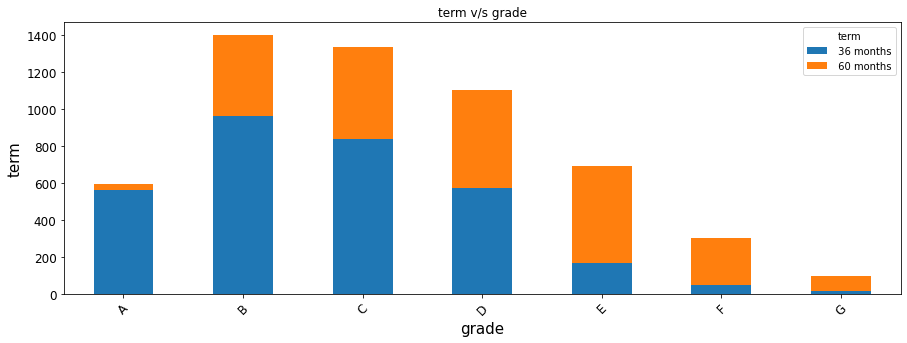

term v.s delinq_2yrs


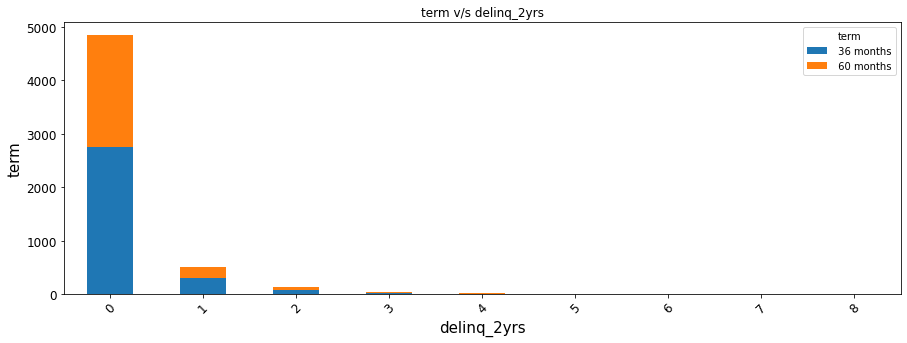

term v.s home_ownership


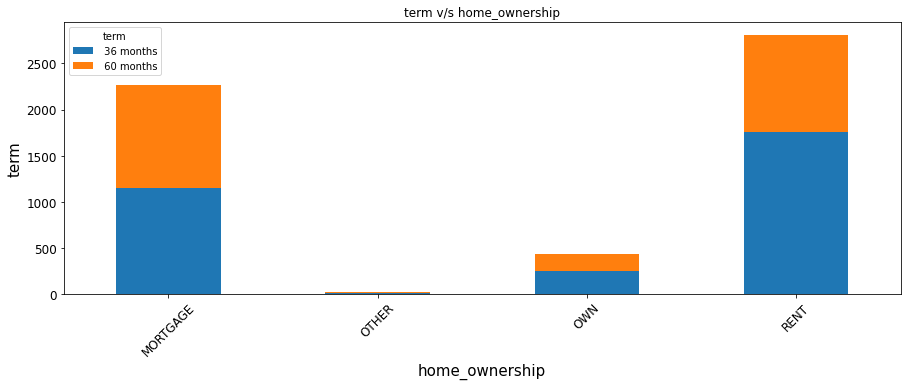

term v.s purpose


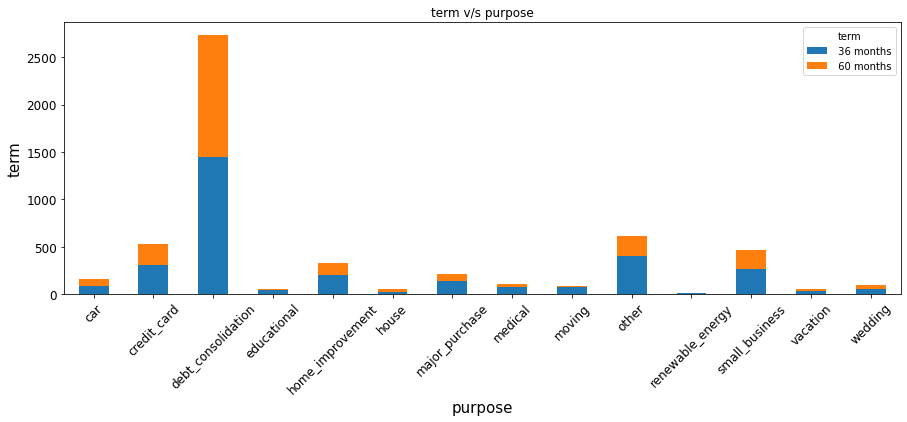

term v.s verification_status


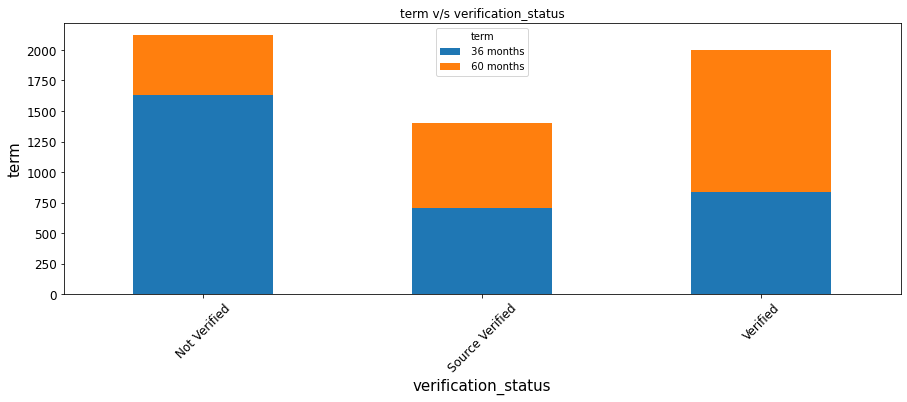

term v.s bin_loan_amnt


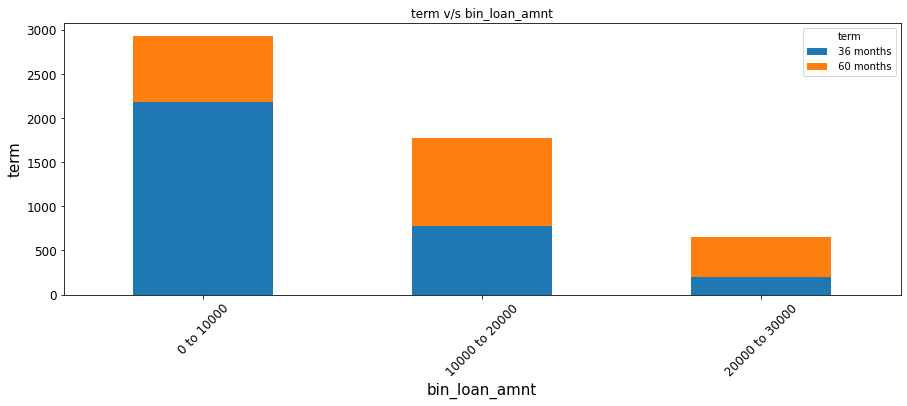

term v.s bin_int_rate


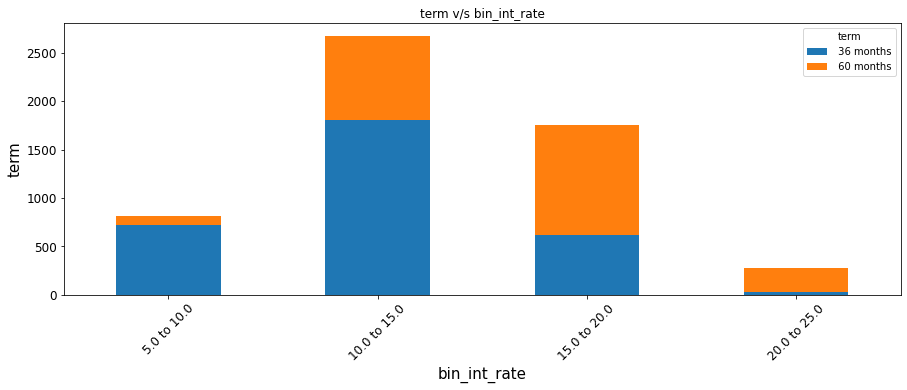

term v.s bin_annual_inc


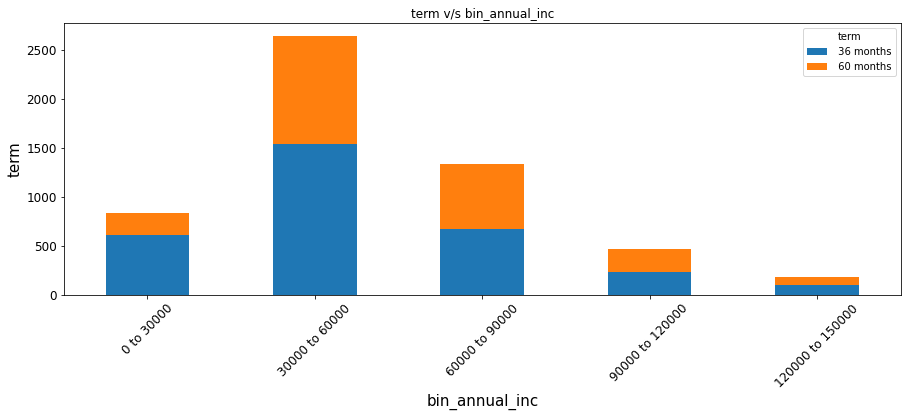

term v.s bin_dti


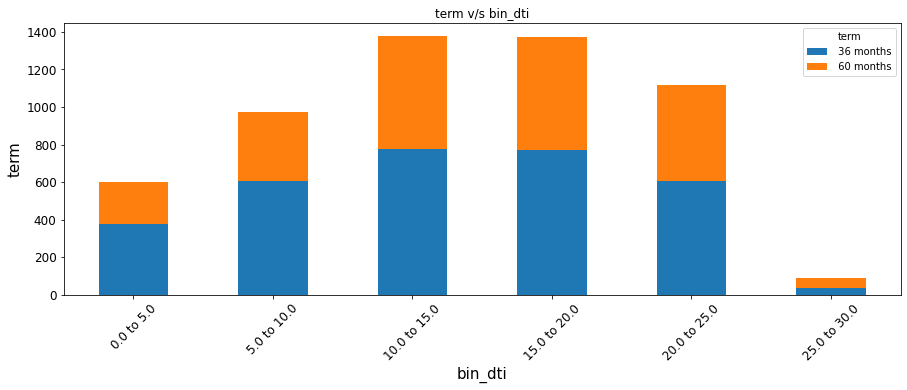

term v.s bin_closed_acc


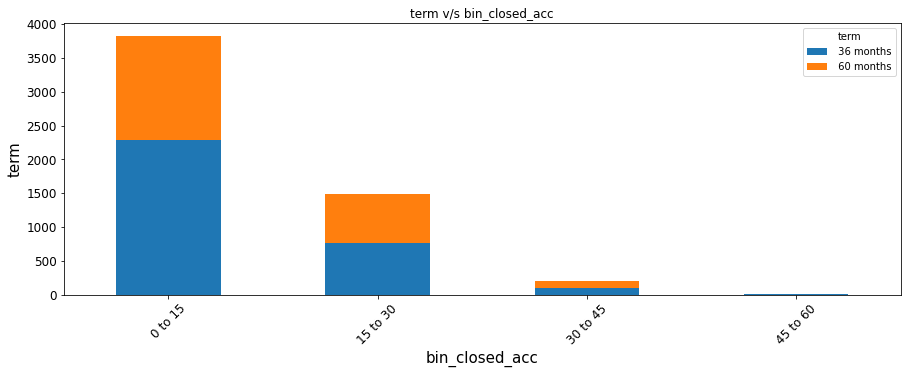

term v.s bin_emp_length


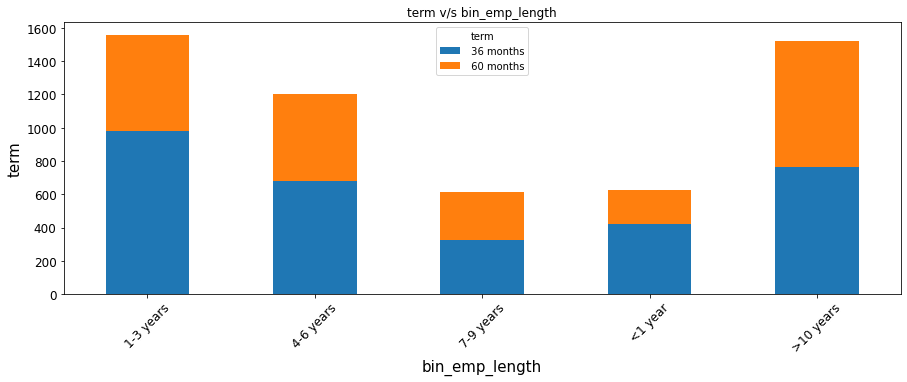

term v.s bin_ear_cre_li_year


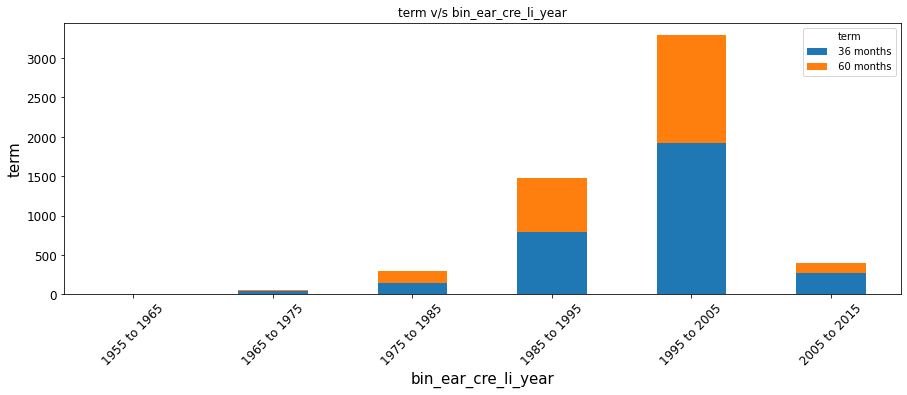

grade v.s delinq_2yrs


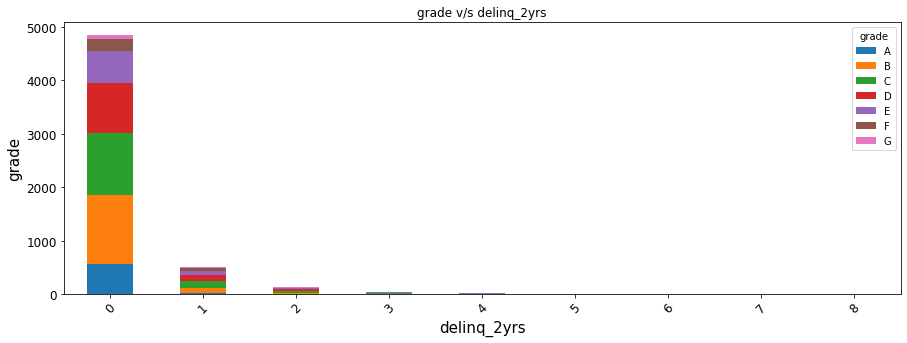

grade v.s home_ownership


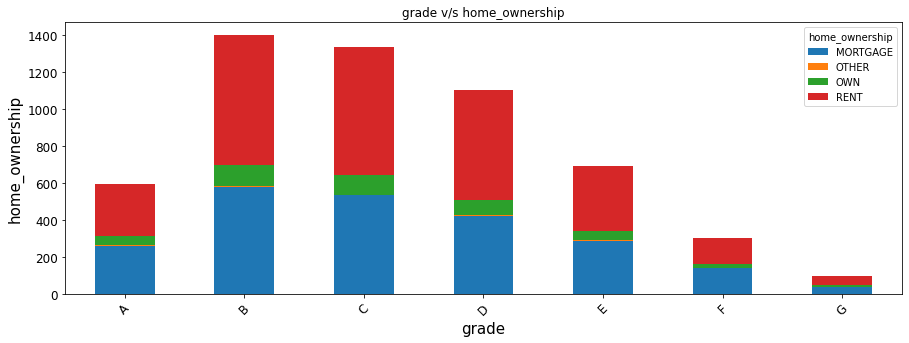

grade v.s purpose


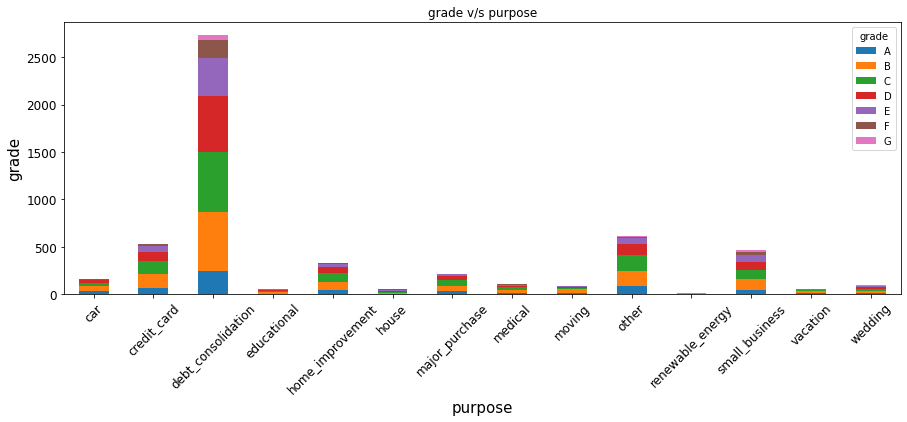

grade v.s verification_status


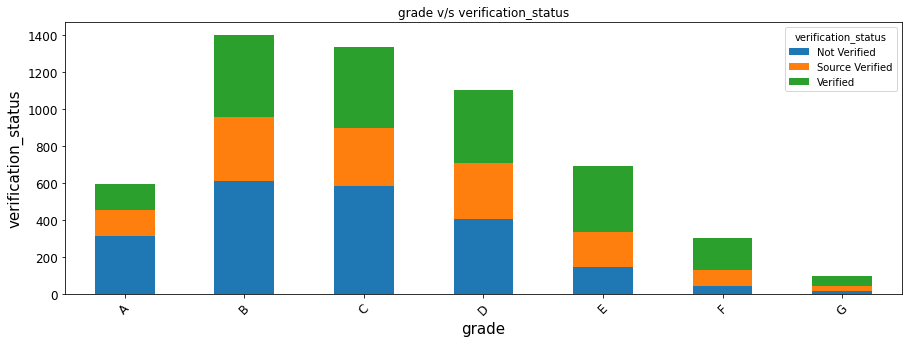

grade v.s bin_loan_amnt


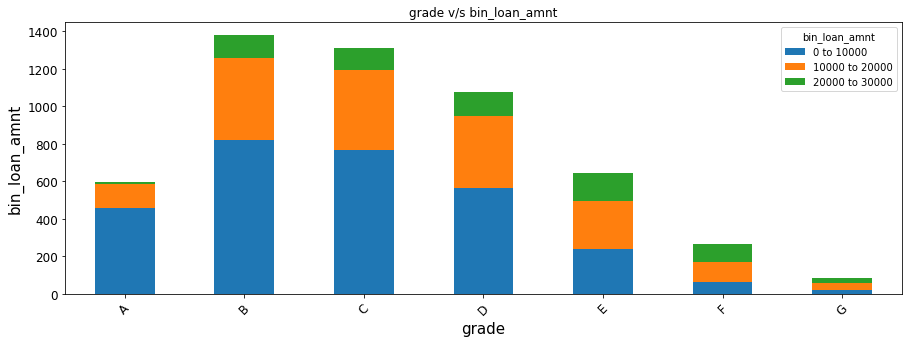

grade v.s bin_int_rate


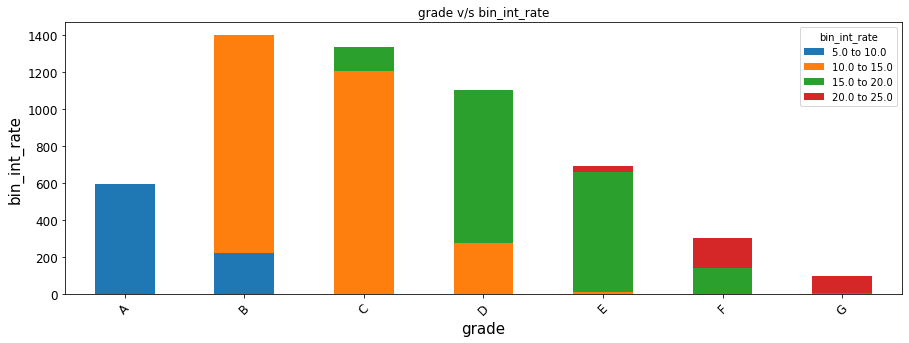

grade v.s bin_annual_inc


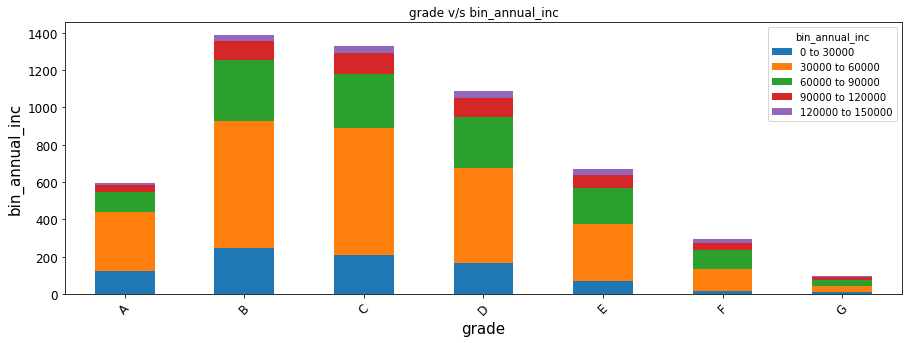

grade v.s bin_dti


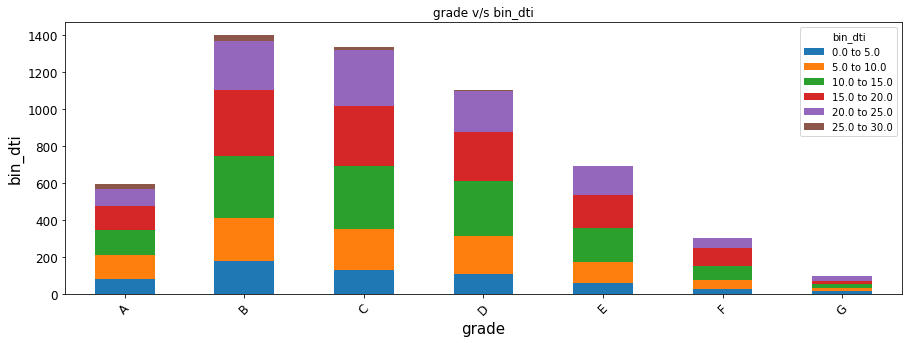

grade v.s bin_closed_acc


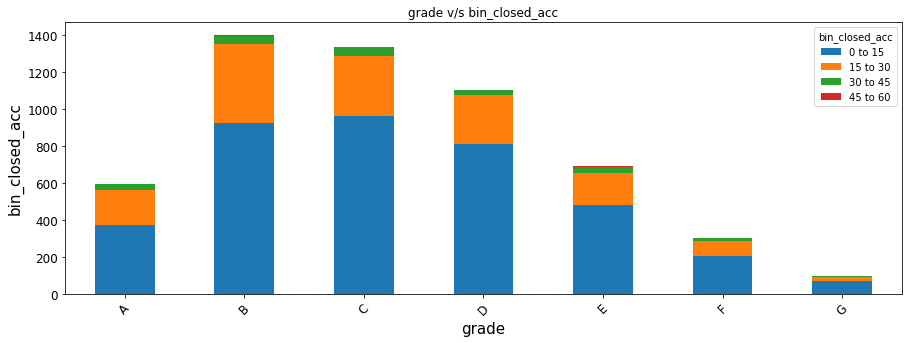

grade v.s bin_emp_length


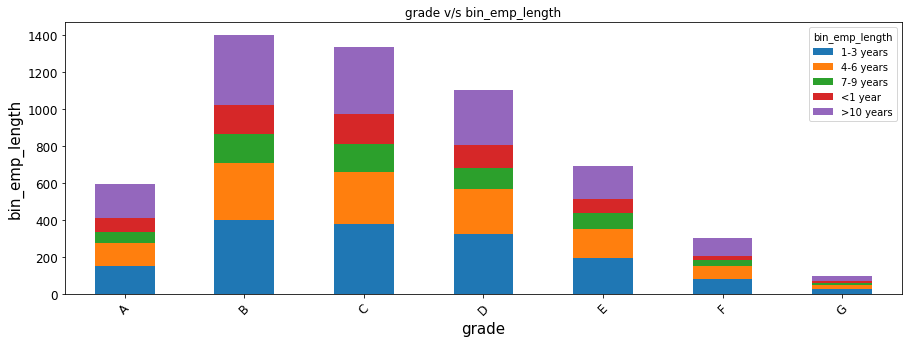

grade v.s bin_ear_cre_li_year


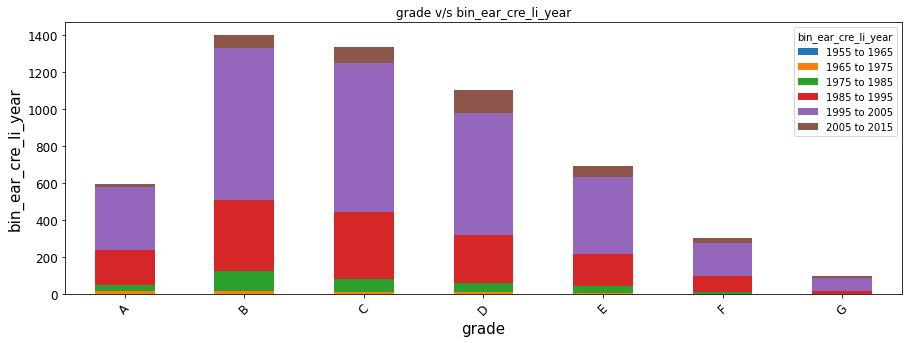

delinq_2yrs v.s home_ownership


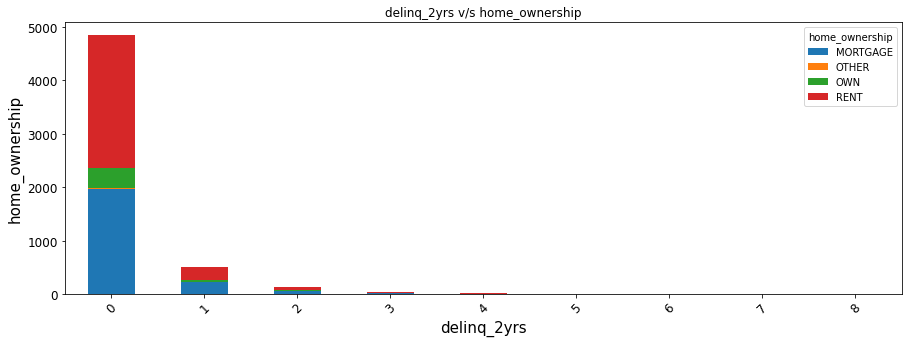

delinq_2yrs v.s purpose


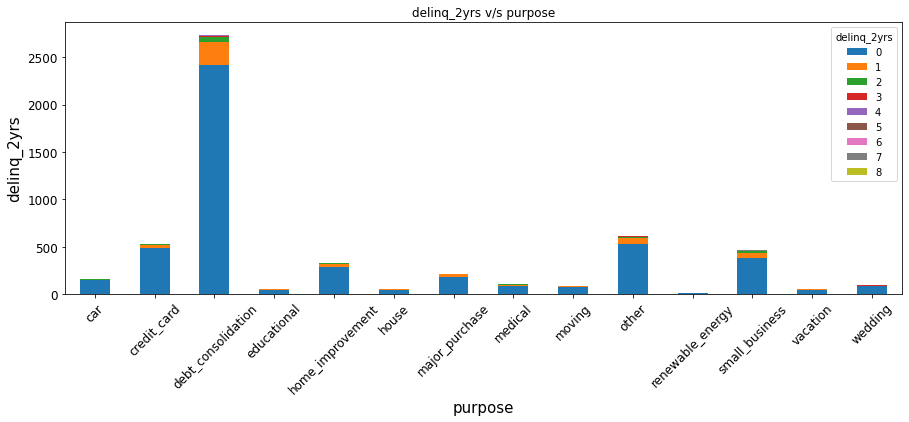

delinq_2yrs v.s verification_status


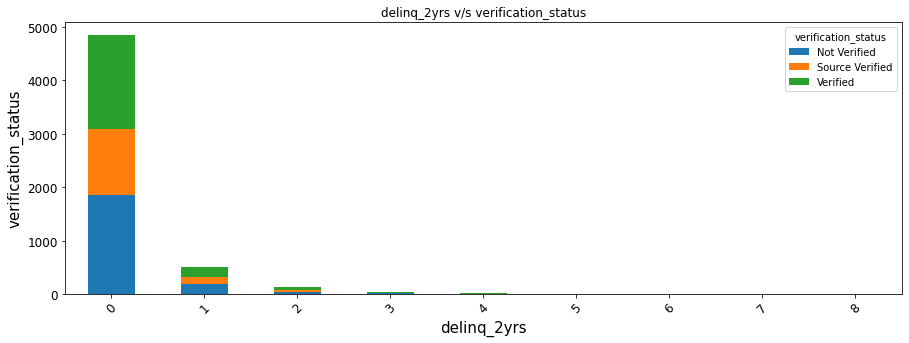

delinq_2yrs v.s bin_loan_amnt


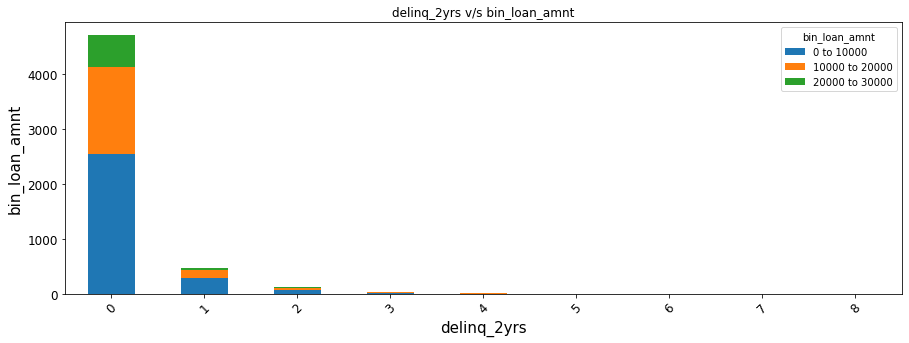

delinq_2yrs v.s bin_int_rate


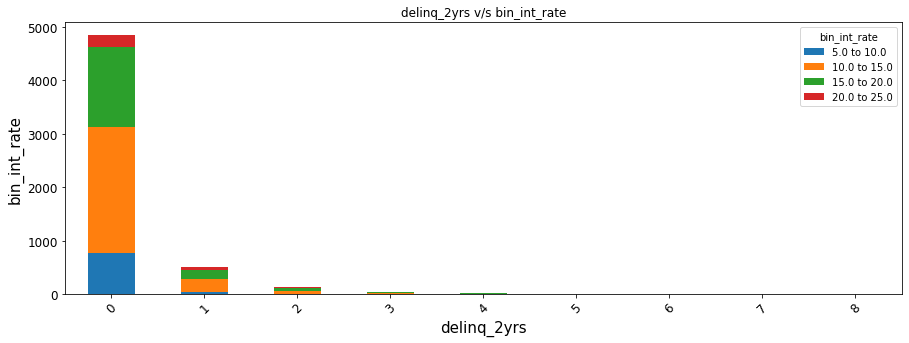

delinq_2yrs v.s bin_annual_inc


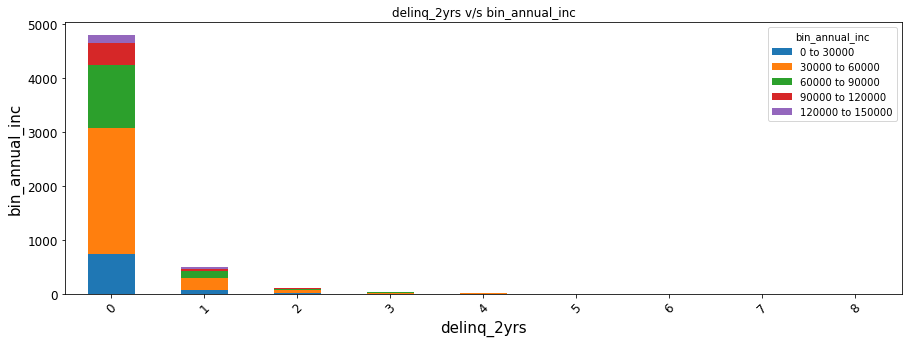

delinq_2yrs v.s bin_dti


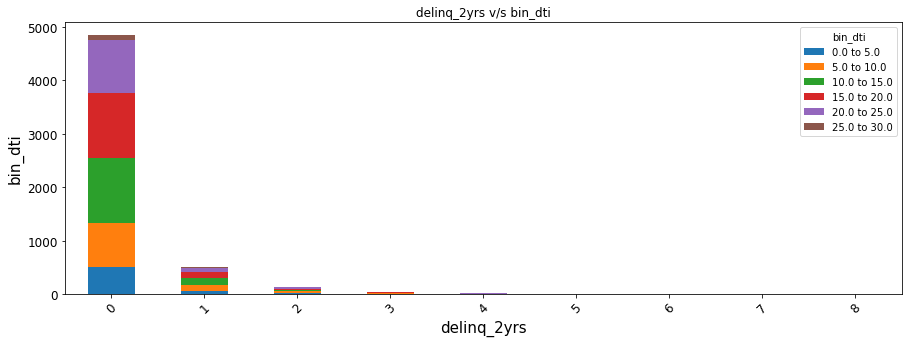

delinq_2yrs v.s bin_closed_acc


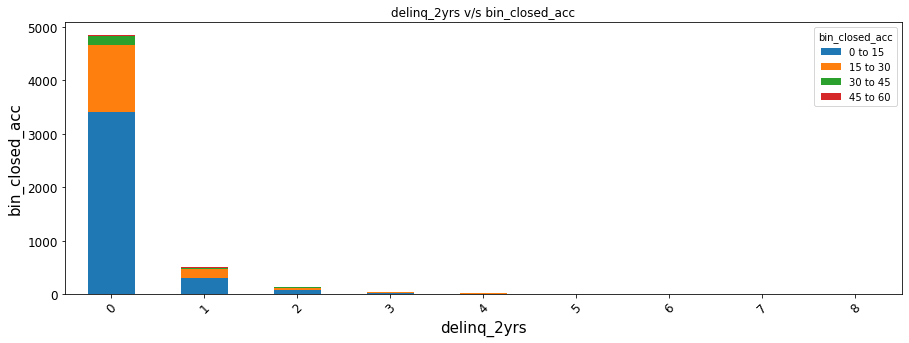

delinq_2yrs v.s bin_emp_length


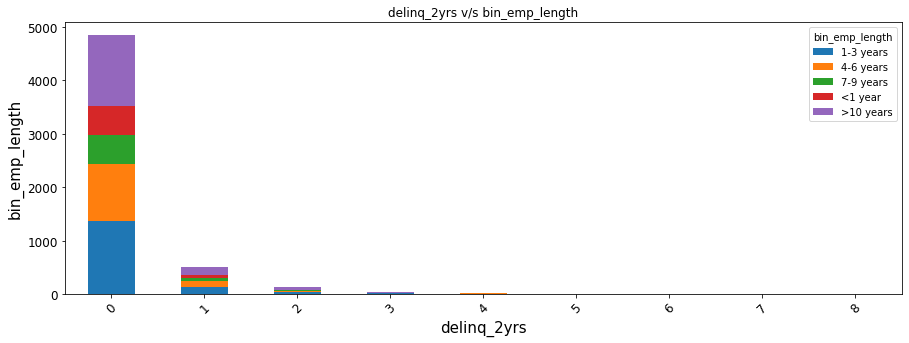

delinq_2yrs v.s bin_ear_cre_li_year


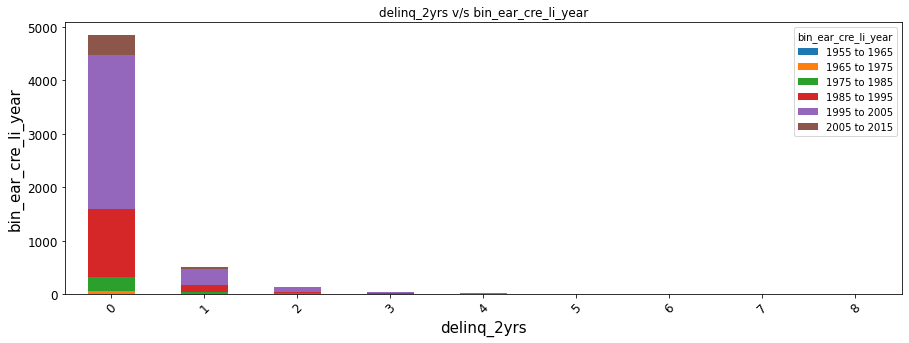

home_ownership v.s purpose


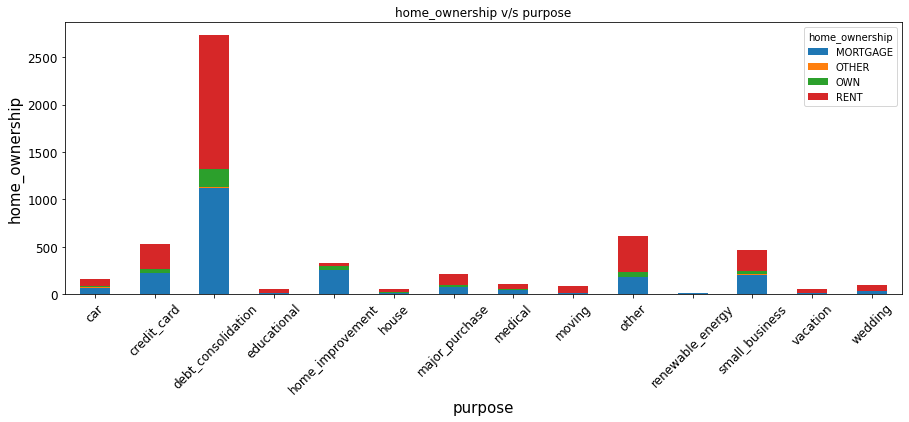

home_ownership v.s verification_status


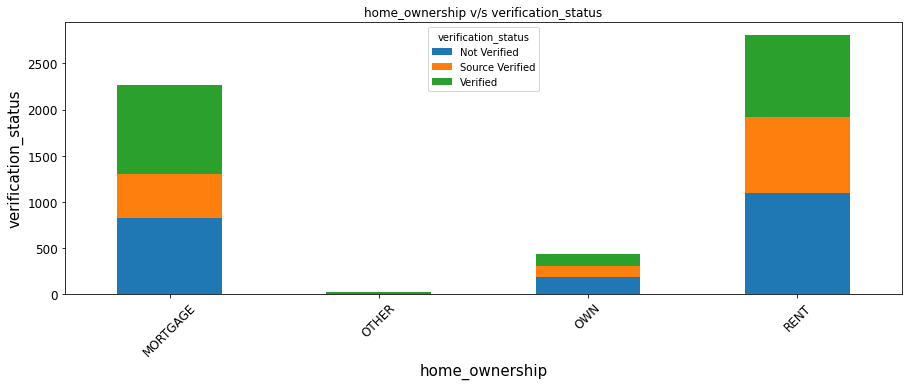

home_ownership v.s bin_loan_amnt


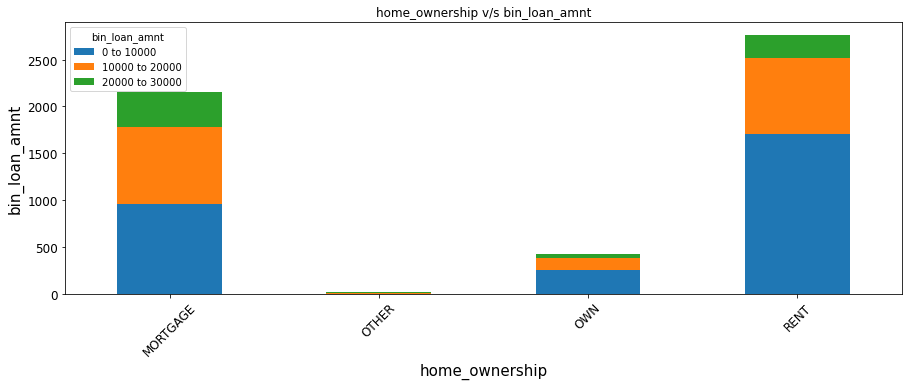

home_ownership v.s bin_int_rate


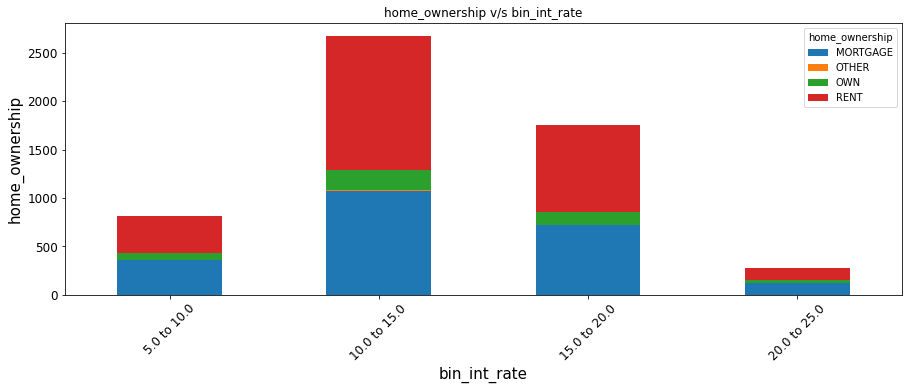

home_ownership v.s bin_annual_inc


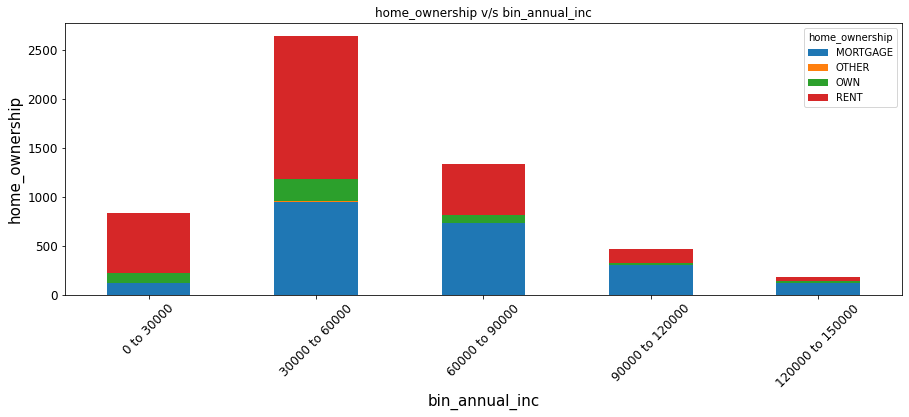

home_ownership v.s bin_dti


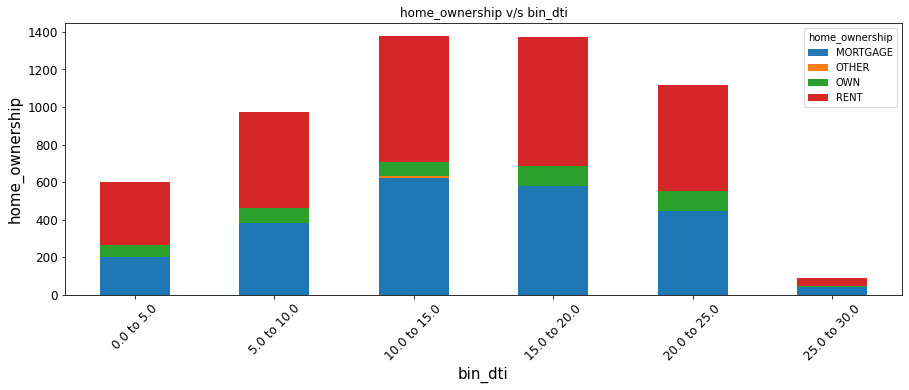

home_ownership v.s bin_closed_acc


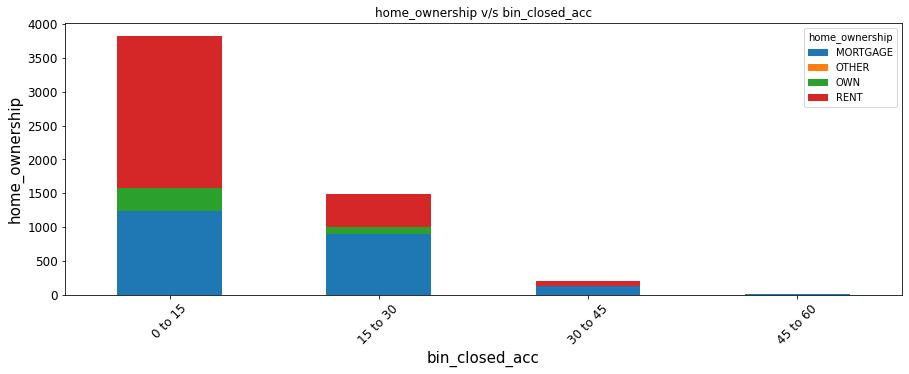

home_ownership v.s bin_emp_length


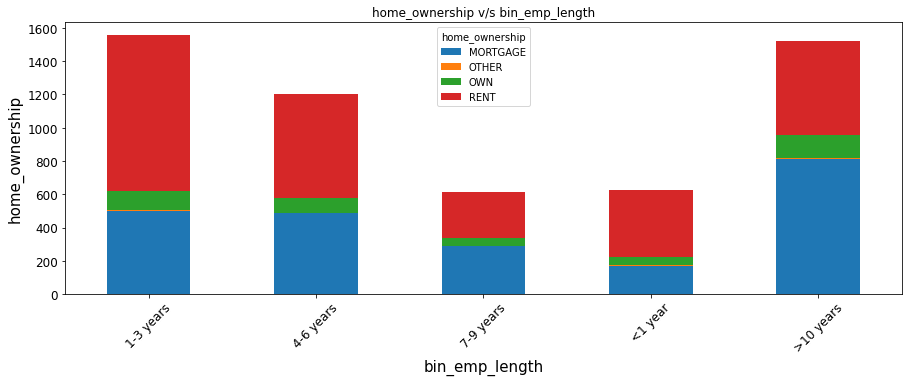

home_ownership v.s bin_ear_cre_li_year


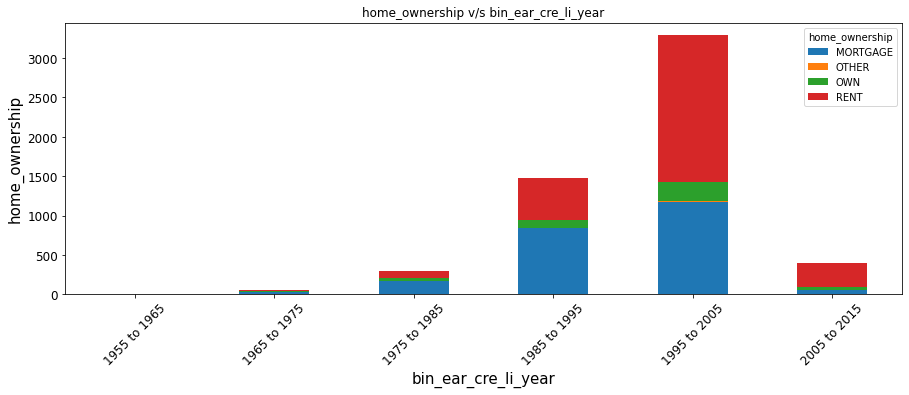

purpose v.s verification_status


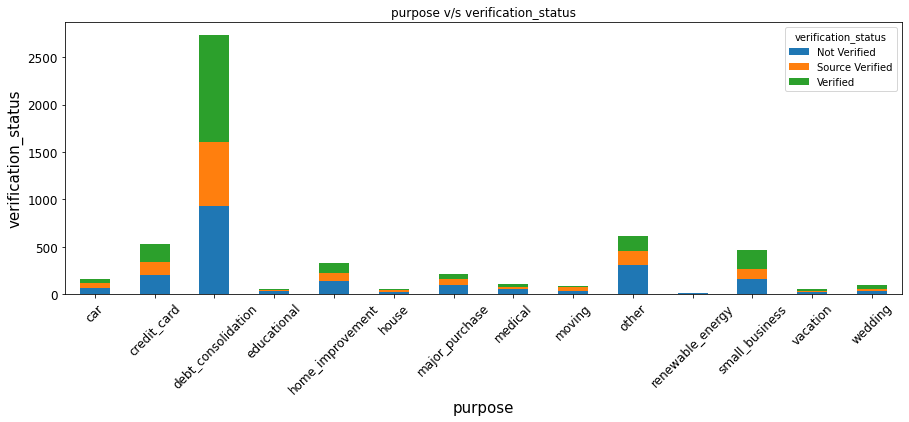

purpose v.s bin_loan_amnt


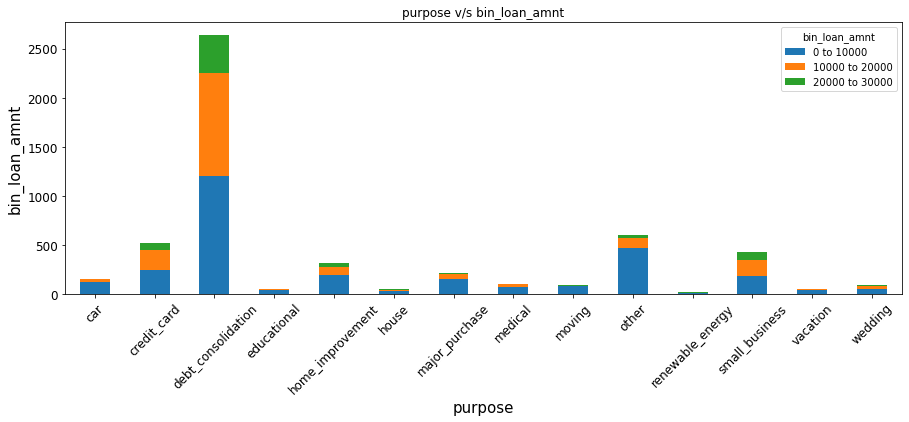

purpose v.s bin_int_rate


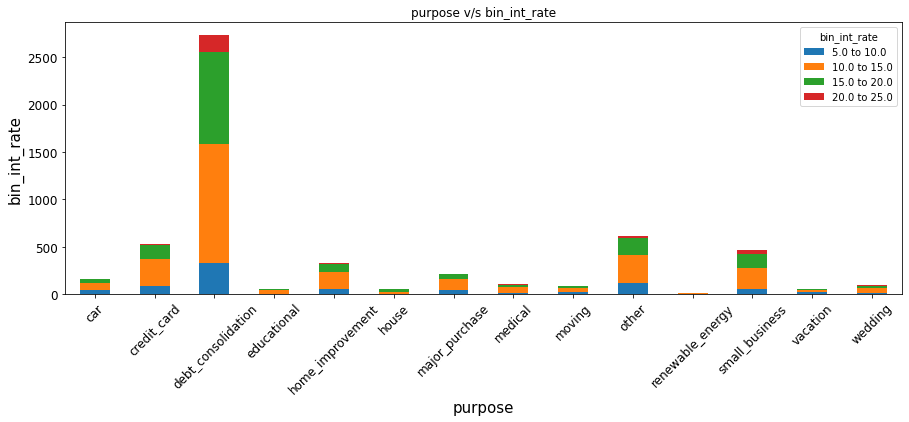

purpose v.s bin_annual_inc


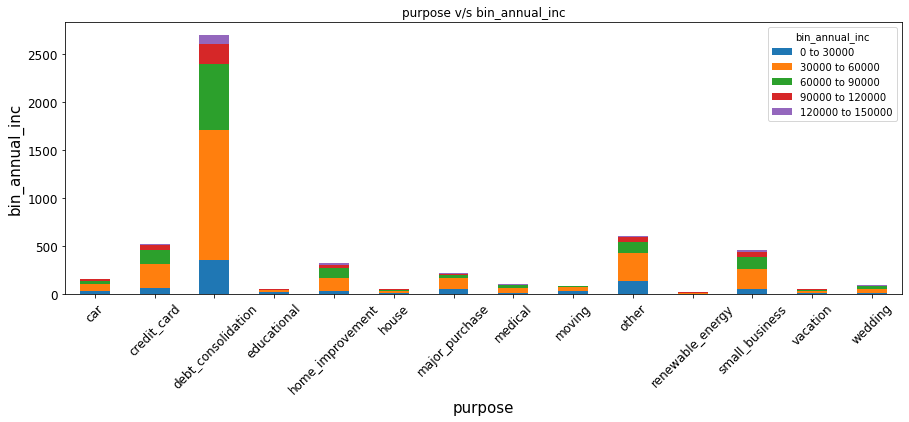

purpose v.s bin_dti


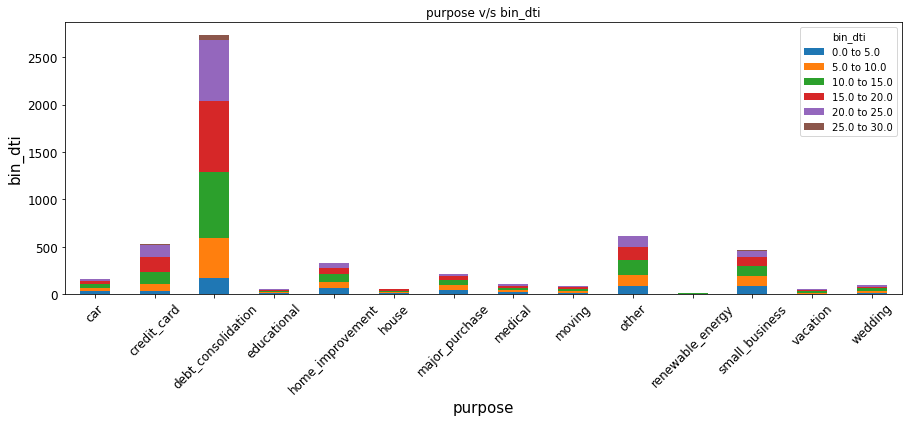

purpose v.s bin_closed_acc


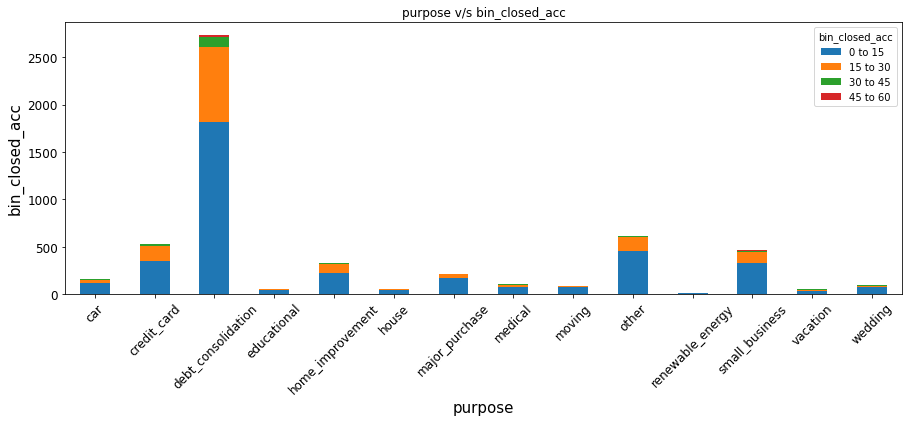

purpose v.s bin_emp_length


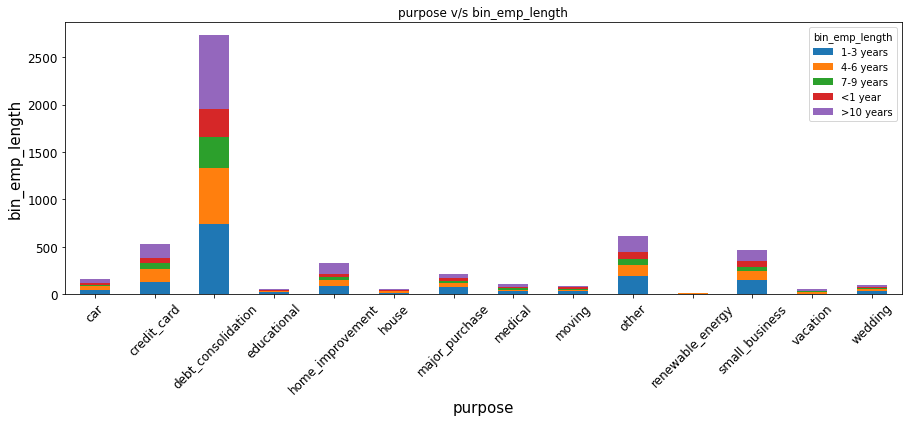

purpose v.s bin_ear_cre_li_year


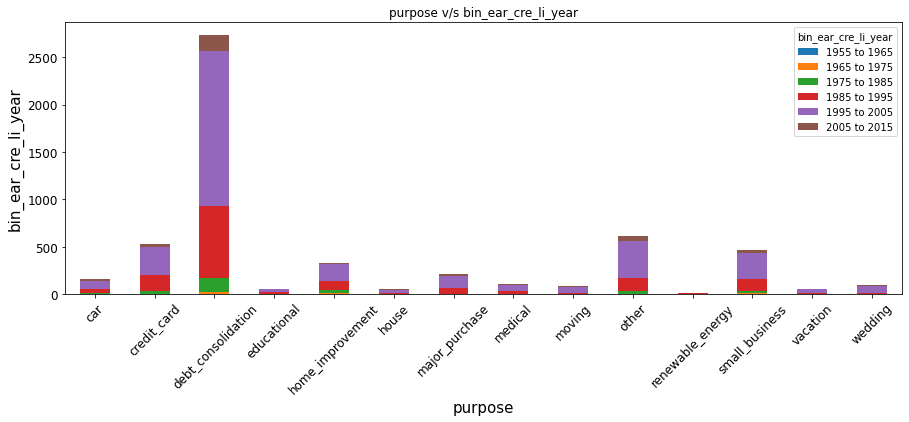

verification_status v.s bin_loan_amnt


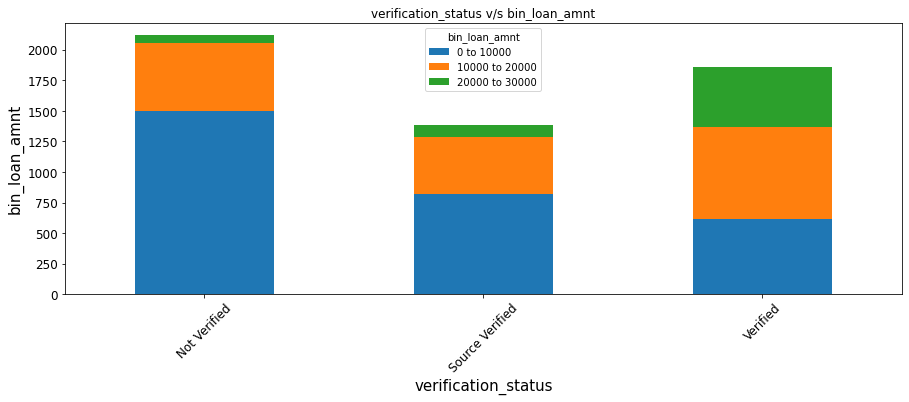

verification_status v.s bin_int_rate


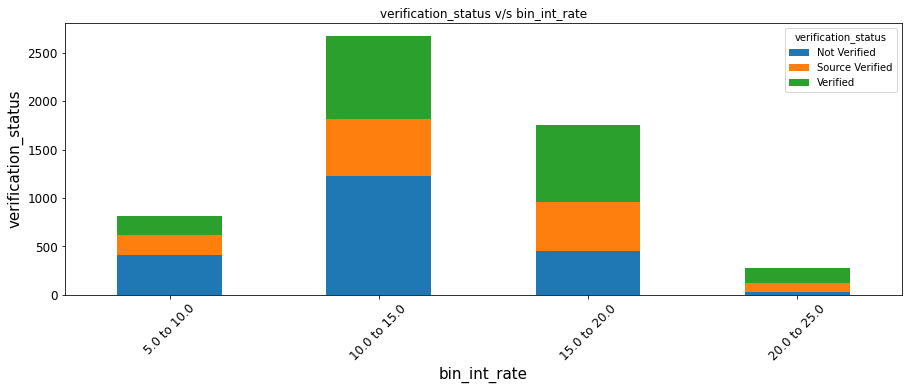

verification_status v.s bin_annual_inc


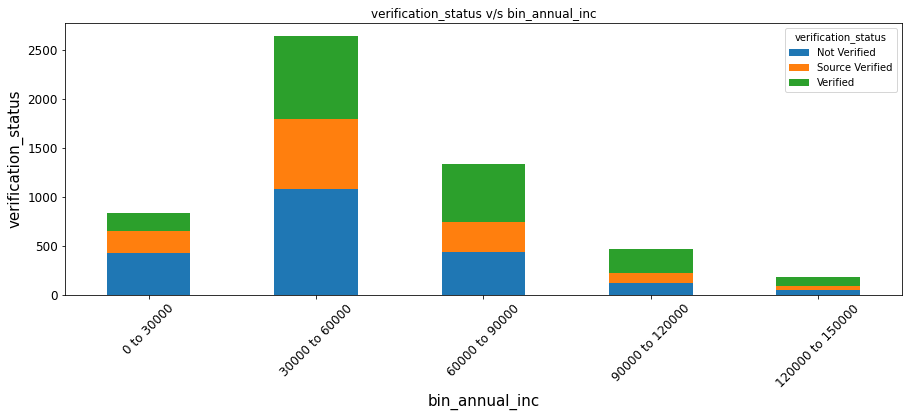

verification_status v.s bin_dti


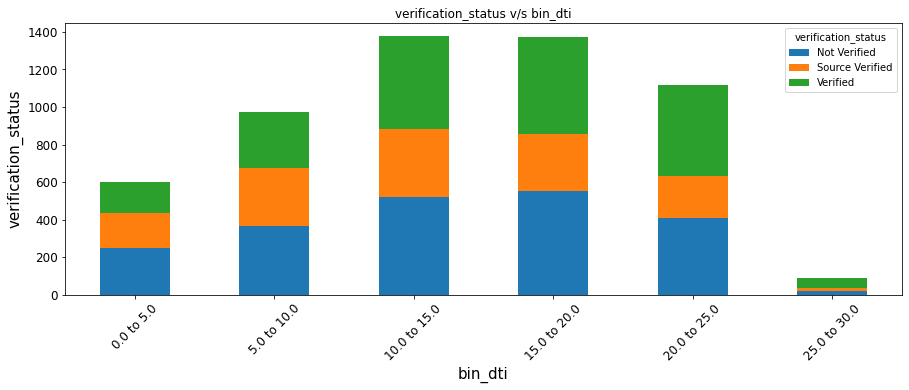

verification_status v.s bin_closed_acc


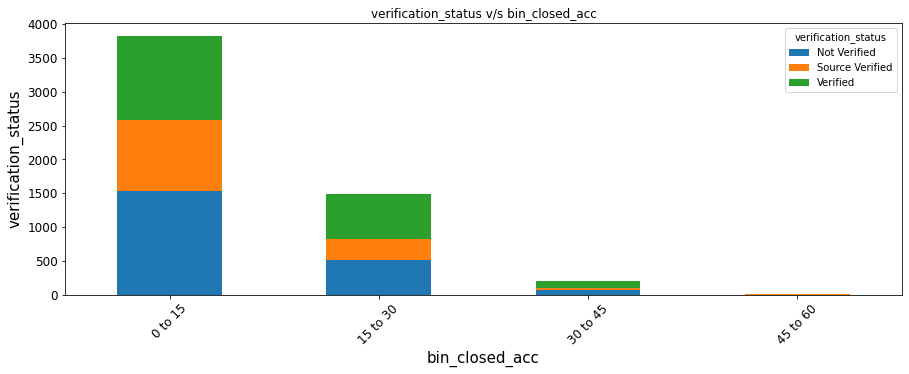

verification_status v.s bin_emp_length


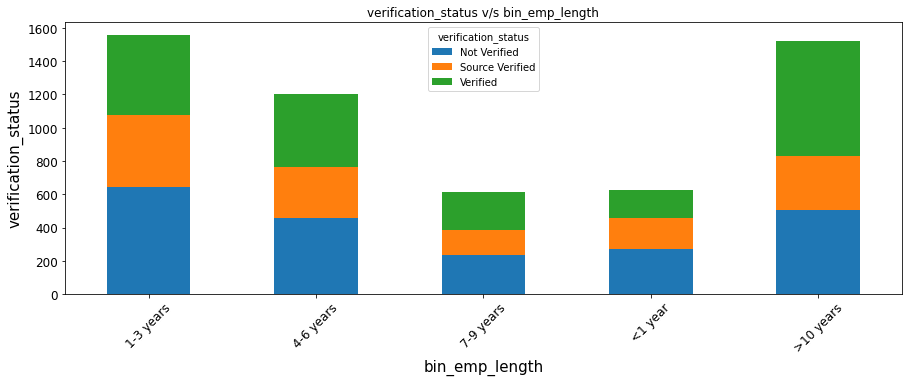

verification_status v.s bin_ear_cre_li_year


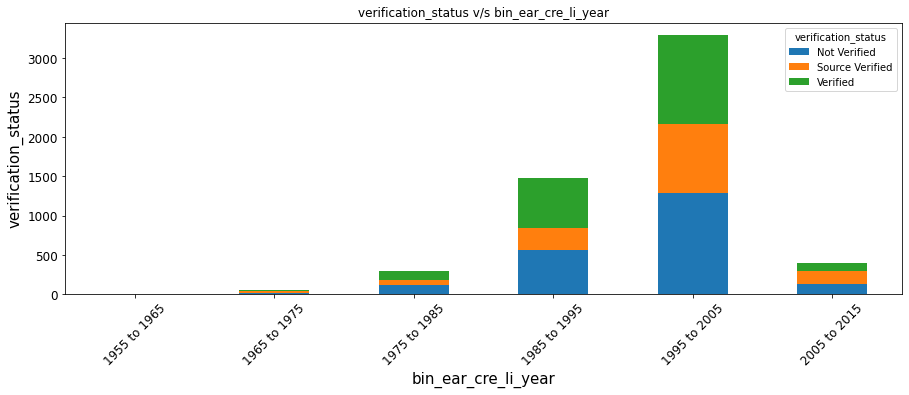

bin_loan_amnt v.s bin_int_rate


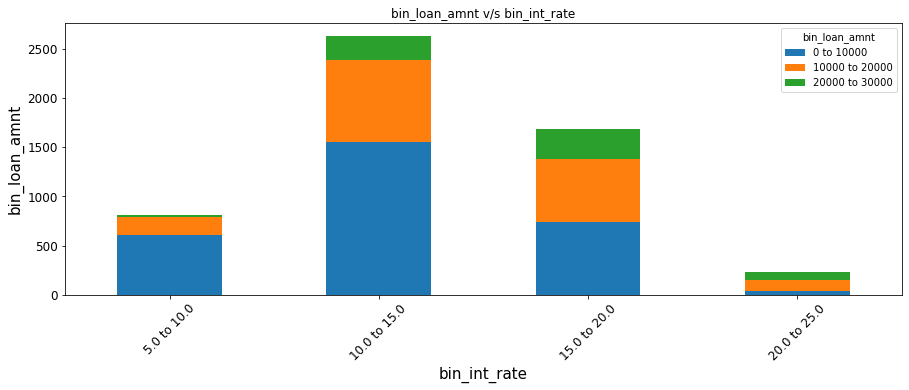

bin_loan_amnt v.s bin_annual_inc


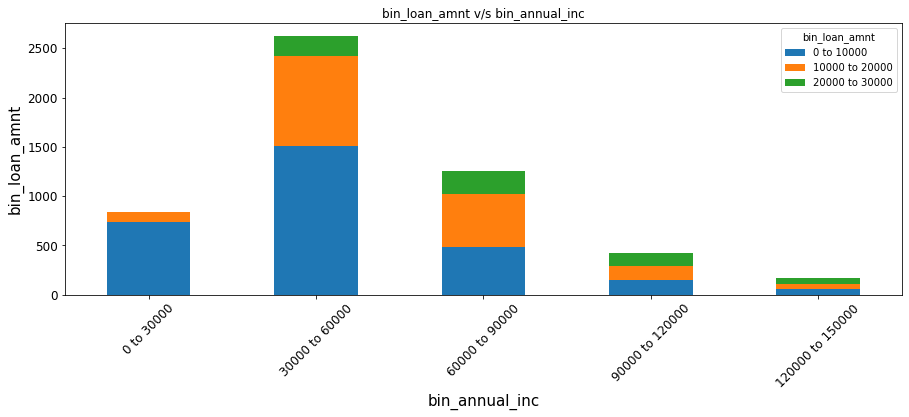

bin_loan_amnt v.s bin_dti


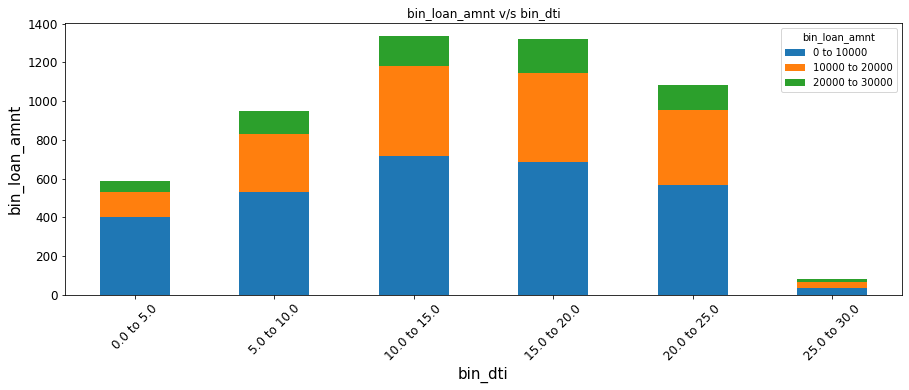

bin_loan_amnt v.s bin_closed_acc


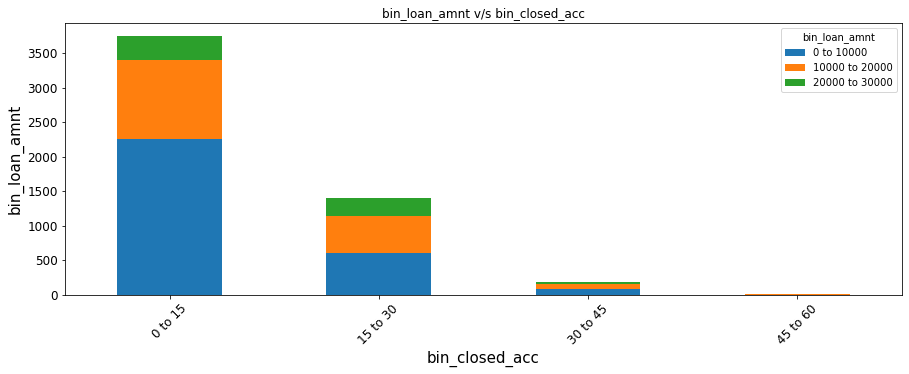

bin_loan_amnt v.s bin_emp_length


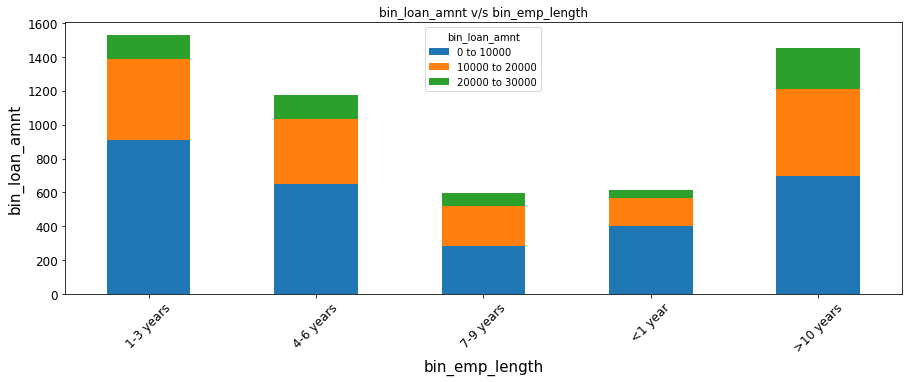

bin_loan_amnt v.s bin_ear_cre_li_year


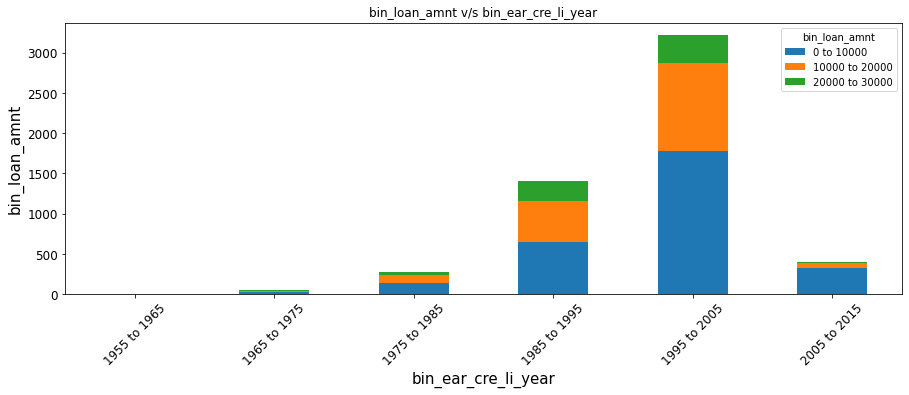

bin_int_rate v.s bin_annual_inc


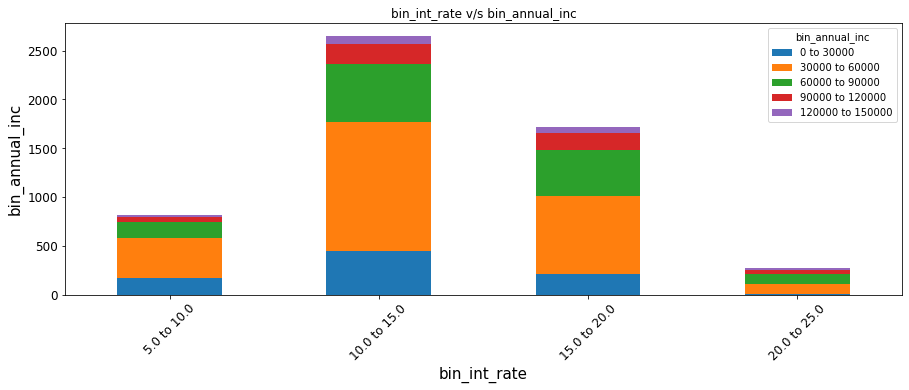

bin_int_rate v.s bin_dti


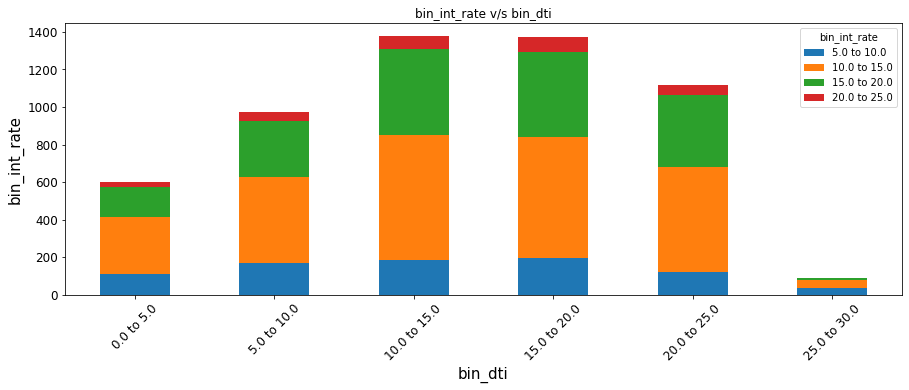

bin_int_rate v.s bin_closed_acc


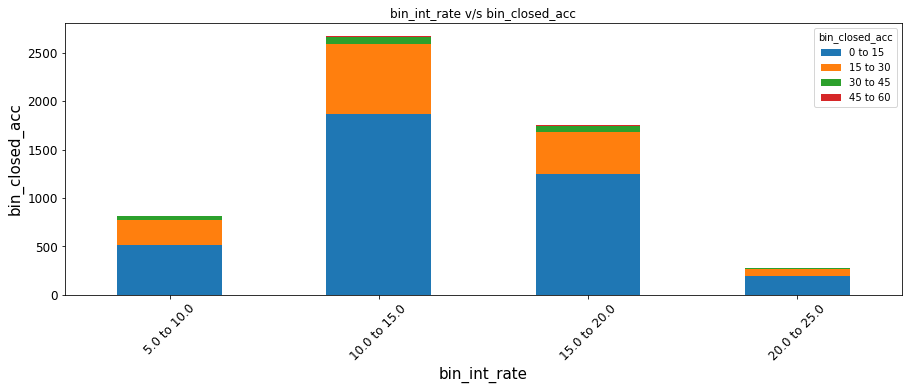

bin_int_rate v.s bin_emp_length


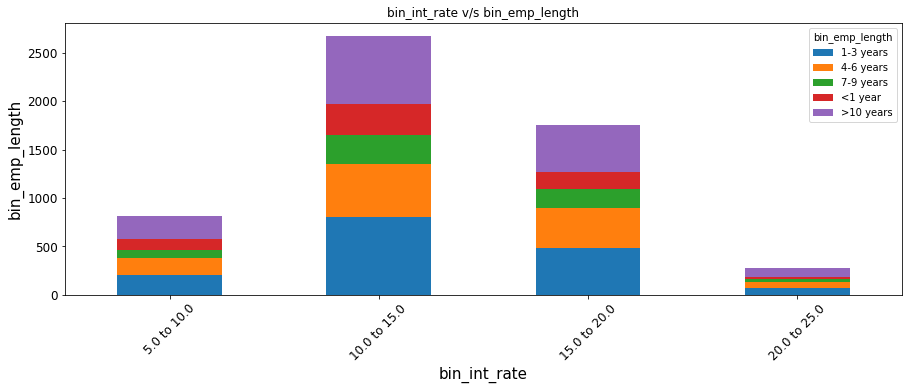

bin_int_rate v.s bin_ear_cre_li_year


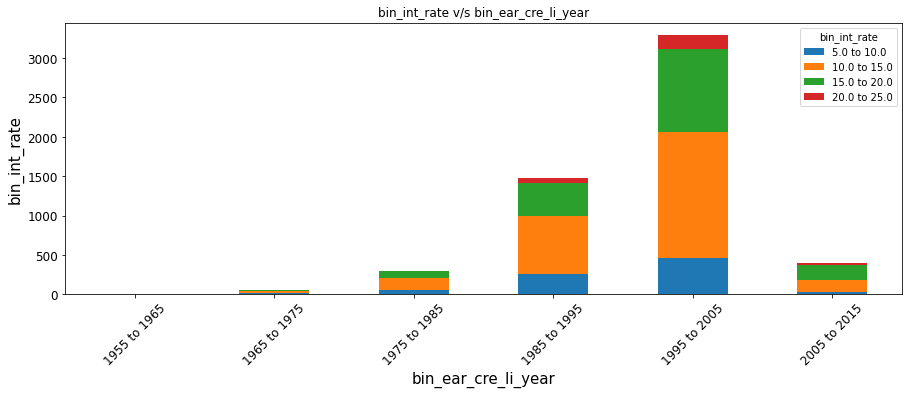

bin_annual_inc v.s bin_dti


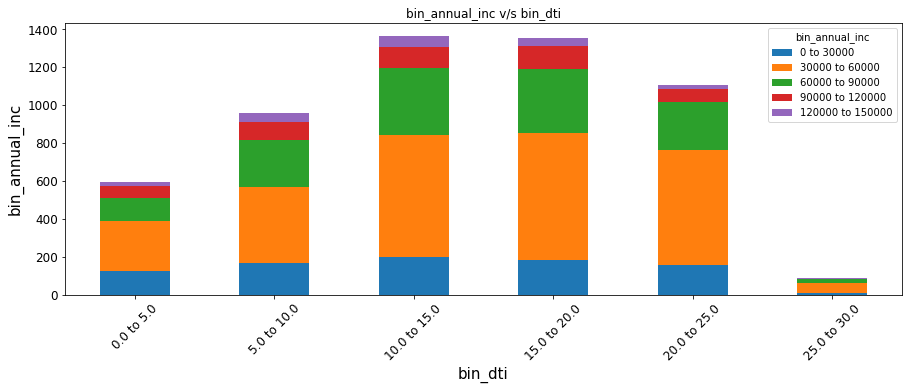

bin_annual_inc v.s bin_closed_acc


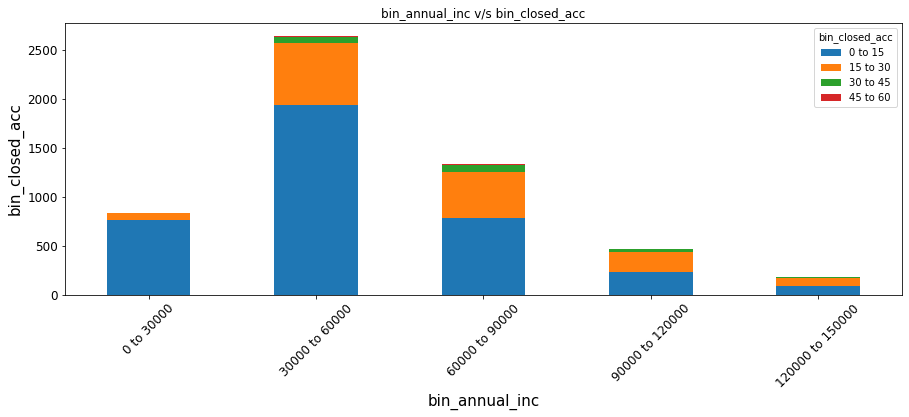

bin_annual_inc v.s bin_emp_length


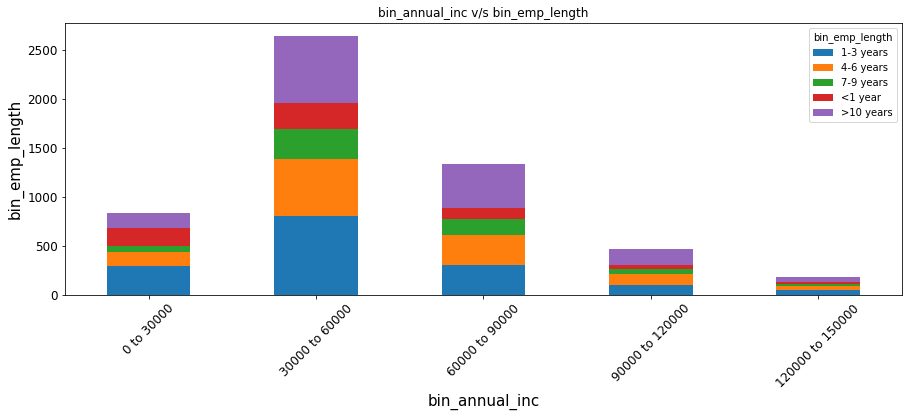

bin_annual_inc v.s bin_ear_cre_li_year


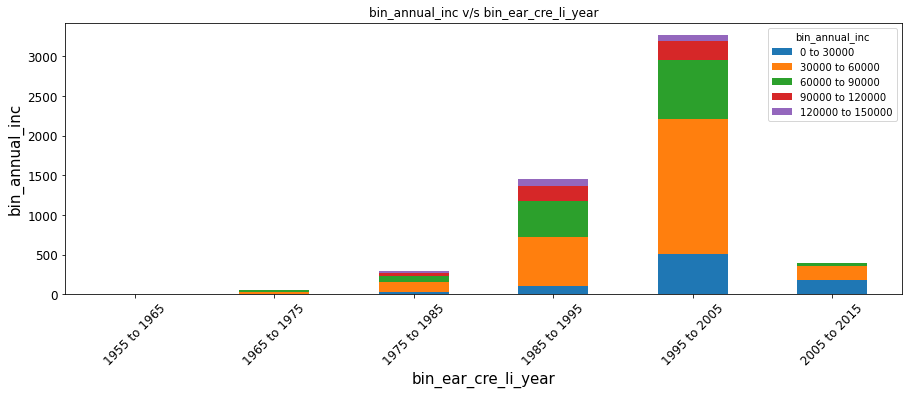

bin_dti v.s bin_closed_acc


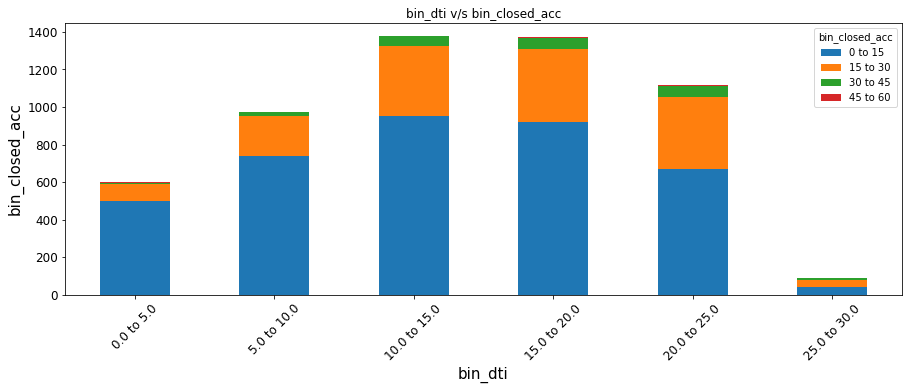

bin_dti v.s bin_emp_length


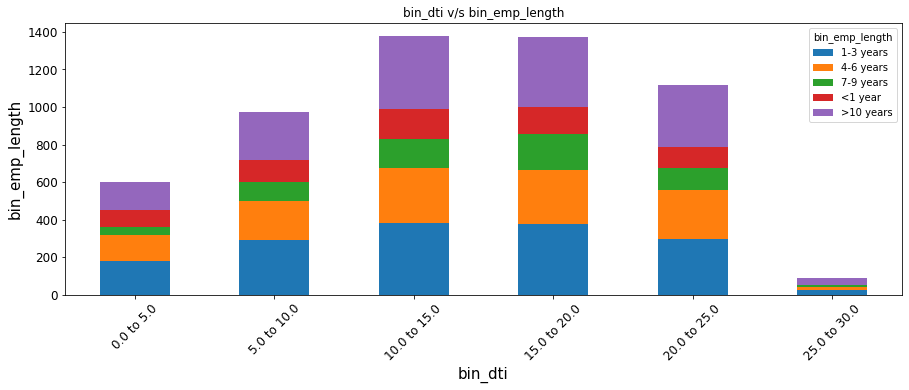

bin_dti v.s bin_ear_cre_li_year


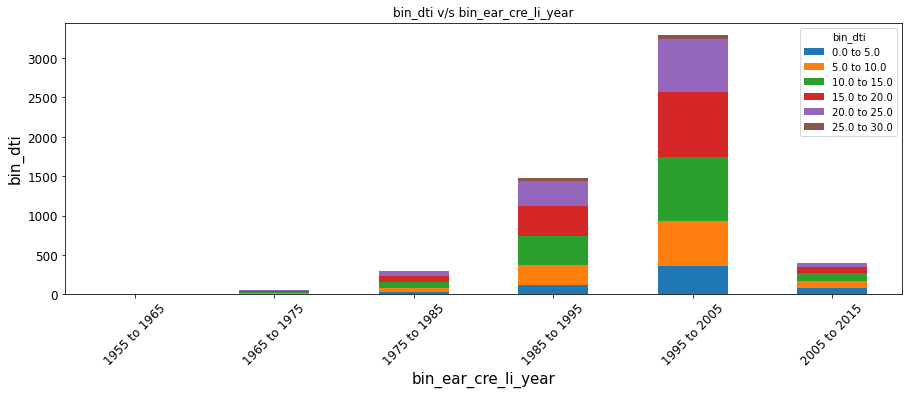

bin_closed_acc v.s bin_emp_length


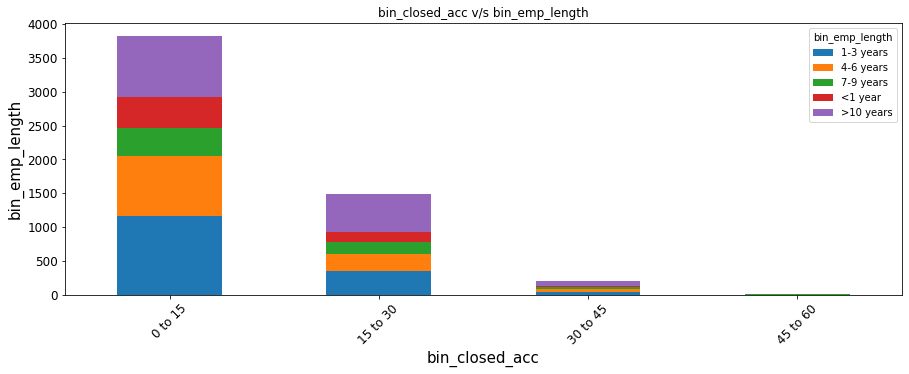

bin_closed_acc v.s bin_ear_cre_li_year


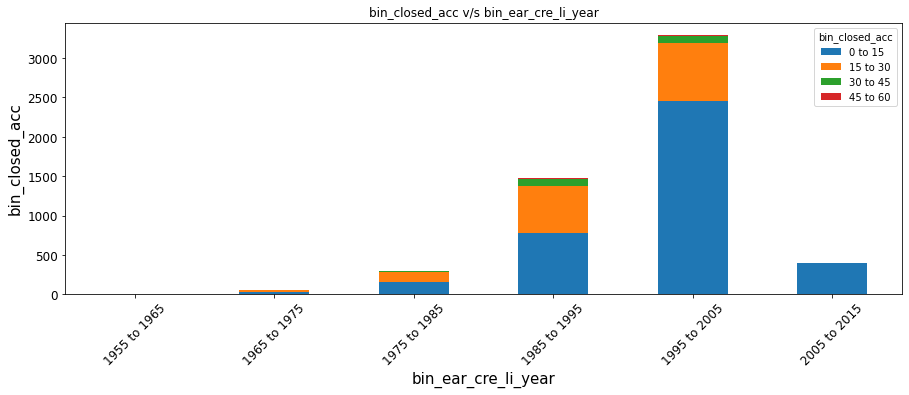

bin_emp_length v.s bin_ear_cre_li_year


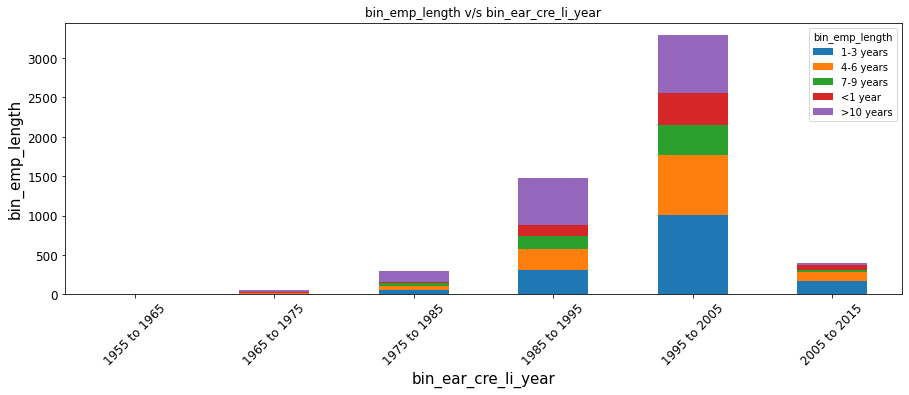

In [217]:
cat_plot_cols=ordered_cat_data+unordered_cat_data+binned_cols
not_req=["earliest_cr_line","open_acc","total_acc","sub_grade","zip_code","addr_state","emp_length"]
comm_list=[]
#Find out unique combinations of columns to view for bivariate analysis
for c1 in cat_plot_cols:
    for c2 in cat_plot_cols:
        if c1!=c2 and not (c1 in not_req) and not (c2 in not_req):
            tup=(c1,c2)
            rev_tup=(c2,c1)
            if not rev_tup in comm_list:
                comm_list.append(tup)
        
for c1,c2 in comm_list:
    print(f"{c1} v.s {c2}")
    # plot_bar_cat(lc_df,c1,c2,0.1,45)
    plot_bar_cat_stack(lc_df,c1,c2,0.1,45,f"{c1} v/s {c2}")

### **Inferences from bivariate analysis**

### **Analysis on More than Two Variables**

In [236]:
lc_df

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,emp_length,annual_inc,verification_status,purpose,addr_state,dti,open_acc,total_acc,delinq_2yrs,earliest_cr_line,bin_emp_length,closed_acc,bin_closed_acc,ear_cre_li_year,bin_ear_cre_li_year,bin_loan_amnt,bin_int_rate,bin_annual_inc,bin_dti,bin_open_acc
1,1077430,2500,60 months,15.27,C,C4,RENT,< 1 year,30000.0,Source Verified,car,GA,1.00,3,4,0,Apr-99,<1 year,1,0 to 15,1999,1995 to 2005,0 to 10000,15.0 to 20.0,0 to 30000,0.0 to 5.0,0 to 10
8,1071795,5600,60 months,21.28,F,F2,OWN,4 years,40000.0,Source Verified,small_business,CA,5.55,11,13,0,Apr-04,4-6 years,2,0 to 15,2004,1995 to 2005,0 to 10000,20.0 to 25.0,30000 to 60000,5.0 to 10.0,10 to 20
9,1071570,5375,60 months,12.69,B,B5,RENT,< 1 year,15000.0,Verified,other,TX,18.08,2,3,0,Sep-04,<1 year,1,0 to 15,2004,1995 to 2005,0 to 10000,10.0 to 15.0,0 to 30000,15.0 to 20.0,0 to 10
12,1064687,9000,36 months,13.49,C,C1,RENT,< 1 year,30000.0,Source Verified,debt_consolidation,VA,10.08,4,9,0,Apr-04,<1 year,5,0 to 15,2004,1995 to 2005,0 to 10000,10.0 to 15.0,0 to 30000,10.0 to 15.0,0 to 10
14,1069057,10000,36 months,10.65,B,B2,RENT,3 years,100000.0,Source Verified,other,CA,7.06,14,29,0,May-91,1-3 years,15,0 to 15,1991,1985 to 1995,0 to 10000,10.0 to 15.0,90000 to 120000,5.0 to 10.0,10 to 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39666,119043,15450,36 months,11.22,C,C4,MORTGAGE,2 years,40000.0,Not Verified,debt_consolidation,VA,13.50,13,29,0,Nov-92,1-3 years,16,15 to 30,1992,1985 to 1995,10000 to 20000,10.0 to 15.0,30000 to 60000,10.0 to 15.0,10 to 20
39667,118823,2500,36 months,12.80,D,D4,MORTGAGE,< 1 year,32000.0,Not Verified,home_improvement,NE,20.00,11,32,0,Jul-92,<1 year,21,15 to 30,1992,1985 to 1995,0 to 10000,10.0 to 15.0,30000 to 60000,15.0 to 20.0,10 to 20
39668,118533,2500,36 months,9.64,B,B4,MORTGAGE,< 1 year,75000.0,Not Verified,home_improvement,NE,20.00,9,35,0,Feb-94,<1 year,26,15 to 30,1994,1985 to 1995,0 to 10000,5.0 to 10.0,60000 to 90000,15.0 to 20.0,0 to 10
39678,113179,1000,36 months,10.59,C,C2,MORTGAGE,2 years,33990.0,Not Verified,wedding,VA,14.47,9,11,0,Jul-04,1-3 years,2,0 to 15,2004,1995 to 2005,0 to 10000,10.0 to 15.0,30000 to 60000,10.0 to 15.0,0 to 10


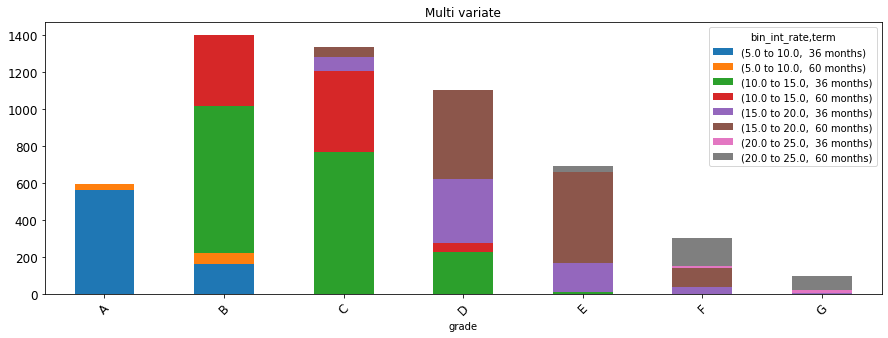

In [228]:
pivot=pd.pivot_table(lc_df,values="id",index="grade",columns=("bin_int_rate","term",),aggfunc=lambda x: len(x.unique()))
pivot.plot(kind='bar', stacked=True,figsize=(15,5),use_index=True,title="Multi variate",rot=45,fontsize=12)
plt.show()


In [234]:
# Employees having employee length 7-9 years and having 30 to 40 open accounts have higher chances of charging off
# For moving and renewable energy,the probabilty of charged off customers is higher for people taking loan amount from 20000 to 30000
# Employee with >10 years of experience takig loan for small business tend to chargeoff more 